In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import re
import os
import random
import torch
print(torch.cuda.is_available(), torch.cuda.device_count())
print(os.getcwd())

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import catboost
from catboost import CatBoostRegressor, Pool

import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance as xgb_plot_importance

import lightgbm
from lightgbm import LGBMRegressor
from lightgbm import plot_importance as lgbm_plot_importance

print(f'CatBoost Version : {catboost.__version__}')
print(f'XGBoost Version  : {xgboost.__version__}')
print(f'LightGBM Version : {lightgbm.__version__}')

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from optuna.integration import CatBoostPruningCallback

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings(action = 'ignore')

# Seed 고정
SEED = 42
def seed_everything(seed) :
    random.seed(seed)
    np.random.seed(seed)
    # tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    torch.use_deterministic_algorithms(True)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
seed_everything(SEED)

True 1
/data/ephemeral/Project
CatBoost Version : 1.2.2
XGBoost Version  : 2.0.2
LightGBM Version : 4.1.0


![data](./code/data/Data_Schema.png)

In [2]:
books = pd.read_csv('./code/data/books.csv')
users = pd.read_csv('./code/data/users.csv')
rating_train = pd.read_csv('./code/data/train_ratings.csv')
rating_test = pd.read_csv('./code/data/test_ratings.csv')
print(books.shape, users.shape, rating_train.shape, rating_test.shape)

(149570, 10) (68092, 3) (306795, 3) (76699, 3)


## `books`

In [3]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149569 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             82343 non-null   object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.4+ MB


### `isbn`
- https://sciencing.com/difference-isbn-13-isbn-10-5890031.html
- group identifier / publisher identifier / title identifier / and check digit로 구성
- Format : X-XXX-XXXXX-X

> **ISBN 확인**
- URL 정보를 사용해서 ISBN이 재대로 입력됐는지 확인

In [4]:
books['img_url_isbn'] = books['img_url'].apply(lambda x : x.split('/')[5].split('.')[0])
books[books['isbn'] != books['img_url_isbn']]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,img_url_isbn


In [5]:
books.drop(columns = 'img_url_isbn', inplace = True)

### `book_author` 결측치 확인
- 실제 저자가 없는 책
- 동일한 `book_title`의 데이터도 없음
- => 동일한 `publisher`의 최빈값으로 대체

In [6]:
books[books['book_title'] == books.loc[books['book_author'].isna(), 'book_title'].values[0]]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
73737,0751352497,A+ Quiz Masters:01 Earth,NaN,1999.0,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,NaN,NaN,NaN,images/0751352497.01.THUMBZZZ.jpg


In [7]:
books.loc[books['book_title'] == books.loc[books['book_author'].isna(), 'book_title'].values[0], 'book_author'] = \
    books.loc[books['publisher'] == books.loc[books['book_author'].isna(), 'publisher'].values[0], 'book_author'].mode().values[0]
print(books['book_author'].isna().sum())

0


In [8]:
# 텍스트 전처리 진행
def text_preprocessing(summary) :
    summary = re.sub("[.,\'\"''""!?]", "", summary)
    summary = re.sub("[^0-9a-zA-Z\\s]", " ", summary)
    summary = re.sub("\s+", " ", summary)
    summary = summary.lower()
    return summary

books['book_title'] = books['book_title'].apply(lambda x : text_preprocessing(x))
books['book_author'] = books['book_author'].apply(lambda x : text_preprocessing(x))
books['publisher'] = books['publisher'].apply(lambda x : text_preprocessing(x))

### `year_of_publication`
- 10년 단위로 범주화

In [9]:
def preprocess_year(x) :
    if x < 1970 :
        return 1970
    elif (x >= 1970) and (x < 1980) :
        return 1980
    elif (x >= 1980) and (x < 1990) :
        return 1990
    elif (x >= 1990) and (x < 2000) :
        return 2000
    else :
        return 2010
    
books['years'] = books['year_of_publication'].apply(preprocess_year)
books['years'].value_counts()

years
2000    72358
2010    46301
1990    23809
1980     5636
1970     1466
Name: count, dtype: int64

### `publisher`
- `isbn`의 앞 4개의 숫자를 활용하여 `new_publisher` 생성

In [10]:
publisher_dict = (books['publisher'].value_counts()).to_dict()
publisher_count_df = pd.DataFrame(list(publisher_dict.items()), columns = ['publisher', 'count'])

publisher_count_df = publisher_count_df.sort_values(by = ['count'], ascending = False)
display(publisher_count_df.head(), books['publisher'].nunique())

,publisher,count
0,harlequin,3006
1,ballantine books,2322
2,pocket,2274
3,penguin books,1943
4,bantam books,1938


11189

In [11]:
modify_list = publisher_count_df[publisher_count_df['count'] > 1]['publisher'].values

for publisher in tqdm.tqdm(modify_list) :
    try :
        number = books[books['publisher'] == publisher]['isbn'].apply(lambda x : x[:4]).value_counts().index[0]
        right_publisher = books[books['isbn'].apply(lambda x : x[:4]) == number]['publisher'].value_counts().index[0]
        books.loc[books[books['isbn'].apply(lambda x : x[:4]) == number].index, 'new_publisher'] = right_publisher
    except :
        pass
    
print(books['new_publisher'].nunique())

  0%|          | 0/5179 [00:00<?, ?it/s]

100%|██████████| 5179/5179 [07:35<00:00, 11.36it/s]

873


In [101]:
books.loc[books['new_publisher'] == 'nan', 'new_publisher'] = books['publisher']
books['new_publisher'].nunique()

1747

### `language`, `category`, `summary`
- `language` & `category` & `summary`가 모두 결측인 행 -> 67227행
- `language` & `summary`만 결측인 행 -> 67227 + 1624행

In [102]:
display(books.loc[books['language'].isna(), ['language', 'category', 'summary']])
display(books.loc[books['language'].isna() & books['category'].notnull()])
display(books.loc[books['language'].isna() & books['summary'].notnull()])

,language,category,summary


,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,years,new_publisher,category_high


,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,years,new_publisher,category_high


- `language`는 `isbn`의 region 정보를 활용하여 결측치 대체

In [14]:
region_code = set([code[:1] for code in books['isbn']])

region_lang = dict()

for code in region_code :
    lang = books.loc[books['isbn'].str.startswith(str(code)), 'language']
    mode = lang.mode()[0] if not code == 'B' else 'en' # 'B'로 시작하는 행들은 모두 NaN여서, 'en'으로 대체
    books.loc[(books['isbn'].str.startswith(str(code))) & (books['language'].isna()), 'language'] = mode

books['language'].isna().sum()

0

### `category`
- 상위 카테고리인 `category_high`를 생성

In [15]:
# 대괄호 삭제
books['category'] = books['category'].apply(lambda x : re.sub('[\W_]+',  ' ', str(x).lower()).strip())

category_df = pd.DataFrame(books['category'].value_counts()).reset_index()
category_df.columns = ['category', 'count']
category_df.head()

,category,count
0,nan,68851
1,fiction,33016
2,juvenile fiction,5835
3,biography autobiography,3326
4,history,1927


In [16]:
books['category_high'] = books['category'].copy()

categories = ['garden', 'crafts', 'physics', 'adventure', 'music', 'fiction', 'nonfiction', 'science', 'science fiction', 'social', 'homicide', 
              'sociology', 'disease', 'religion', 'christian', 'philosophy', 'psycholog', 'mathemat', 'agricult', 'environmental',
              'business', 'poetry', 'drama', 'literary', 'travel', 'motion picture', 'children', 'cook', 'literature', 'electronic', 
              'humor', 'animal', 'bird', 'photograph', 'computer', 'house', 'ecology', 'family', 'architect', 'camp', 'criminal', 'language', 'india']

for category in categories :
    books.loc[books[books['category'].str.contains(category, na = False)].index, 'category_high'] = category

In [17]:
category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
category_high_df.columns = ['category', 'count']
category_high_df.head(10)

,category,count
0,nan,68851
1,fiction,39678
2,biography autobiography,3326
3,history,1927
4,religion,1824
5,nonfiction,1427
6,humor,1291
7,social,1271
8,business,1146
9,cook,1125


In [18]:
# 5개 이하인 항목은 others
others_list = category_high_df[category_high_df['count'] < 5]['category'].values
print(len(others_list))

books.loc[books[books['category_high'].isin(others_list)].index, 'category_high'] = 'others'

2856


In [19]:
books['category_high'] = books['category_high'].replace('nan', np.nan)
books['category_high'] = books['category_high'].replace('unknown', np.nan)
print(books['category_high'].isna().sum())

books['category_high'].fillna('fiction', inplace = True)

68851


In [20]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             149570 non-null  object 
 7   category             149570 non-null  object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
 10  years                149570 non-null  int64  
 11  new_publisher        149570 non-null  object 
 12  category_high        149570 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 14.8+ MB


In [103]:
books.to_csv('./code/data/books_text_preprocessed.csv', index = False)

## `users`

In [22]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


### `city`, `state`, `country` 전처리

In [23]:
users['location'] = users['location'].str.replace(r'[^a-zA-Z:,]', '', regex = True)

users['city'] = users['location'].apply(lambda x : x.split(',')[0].strip())
users['state'] = users['location'].apply(lambda x : x.split(',')[1].strip())
users['country'] = users['location'].apply(lambda x : x.split(',')[2].strip())

users = users.replace('na', np.nan)
users = users.replace('', np.nan)

users[['location', 'city', 'state', 'country']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   location  68092 non-null  object
 1   city      67963 non-null  object
 2   state     64838 non-null  object
 3   country   65968 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


In [24]:
modify_location = users[(users['country'].isna())&(users['city'].notnull())]['city'].values
location = users[(users['location'].str.contains('seattle'))&(users['country'].notnull())]['location'].value_counts().index[0]

location_list = []
for location in tqdm.tqdm(modify_location) :
    try :
        right_location = users[(users['location'].str.contains(location))&(users['country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except :
        pass

for location in tqdm.tqdm(location_list) :
    users.loc[users[users['city'] == location.split(',')[0]].index, 'state'] = location.split(',')[1]
    users.loc[users[users['city'] == location.split(',')[0]].index, 'country'] = location.split(',')[2]

  0%|          | 0/2113 [00:00<?, ?it/s]

100%|██████████| 1963/1963 [00:19<00:00, 100.94it/s]


- `country`의 오타나 오기입되어 있는 값 처리
    - canada -> 'canada', 'cananda', 'vvh', 'lkjlj'
    - italy -> 'italia', 'italy', 'litalia', 'ineurope'
    - phillipines -> 'phillipines', 'phillippines'
    - spain -> 'catalunyaspain', 'spain'
    - unitedkingdom -> 'unitedkingdom', 'usacurrentlylivinginengland', 'unitedkindgonm',    'obviously'
    - usa -> 'unitedstates', 'unitedstaes', 'unitedstatesofamerica', 'usa', 'usanow', 'ysa',    'csa', 'anystate', 'usacanada'
    - uruguay -> 'urugua', 'uruguay'

In [25]:
print(f'Before : {users["country"].nunique()}')
country_mapping = {
    'canada': ['canada', 'cananda', 'vvh', 'lkjlj'],
    'italy': ['italia', 'italy', 'litalia', 'ineurope'],
    'phillipines': ['phillipines', 'phillippines'],
    'spain': ['catalunyaspain', 'spain'],
    'unitedkingdom': ['unitedkingdom', 'usacurrentlylivinginengland', 'unitedkindgonm', 'obviously'],
    'usa': ['unitedstates', 'unitedstaes', 'unitedsates', 'unitedstatesofamerica', 'usa', 'usanow', 'ysa', 'csa', 'anystate', 'usacanada'],
    'uruguay': ['urugua', 'uruguay']
}

for target_country, aliases in country_mapping.items() :
    users['country'].replace(aliases, target_country, inplace = True)

print(f'After  : {users["country"].nunique()}')

Before : 268
After  : 258


In [26]:
# 10개 이하의 country를 others로 변환
others = users['country'].value_counts()[users['country'].value_counts() < 10].index
for country in tqdm.tqdm(others) :
    try :
        users.loc[(users['country'] == country), 'country'] = 'others'
    except :
        pass

100%|██████████| 205/205 [00:00<00:00, 220.85it/s]


In [27]:
# 나머지 결측치에 대해서도 others로 변환
users['country'] = users['country'].fillna('others')
print(users['country'].nunique())

54


In [28]:
city2idx = {v:k for k,v in enumerate(users['city'].unique())}
state2idx = {v:k for k,v in enumerate(users['state'].unique())}
country2idx = {v:k for k,v in enumerate(users['country'].unique())}

users['city'] = users['city'].map(city2idx)
users['state'] = users['state'].map(state2idx)
users['country'] = users['country'].map(country2idx)

### `age`
- 국가별 `age`의 중앙값으로 대체
- 국가별 `age`의 중앙값이 존재하지 않는 경우, 전체 `age`의 중앙값으로 대체

In [29]:
country_age_median = users.groupby('country')['age'].median()
users['age'] = users.apply(lambda x : country_age_median[x['country']] if pd.isna(x['age']) else x['age'], axis = 1)

global_age_median = users['age'].median()
users['age'].fillna(global_age_median, inplace = True)
print(users['age'].isna().sum())

0


- 10살 단위 연령대로 분할하여 `new_age` 변수 생성

In [30]:
users['new_age'] = ((users['age'] // 10) * 10).astype(int)
users[['age', 'new_age']]

,age,new_age
0,33.0,30
1,49.0,40
2,34.0,30
3,30.0,30
4,36.0,30
...,...,...
68087,54.0,50
68088,74.0,70
68089,36.0,30
68090,33.0,30


In [31]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       68092 non-null  float64
 3   city      68092 non-null  int64  
 4   state     68092 non-null  int64  
 5   country   68092 non-null  int64  
 6   new_age   68092 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 3.6+ MB


In [32]:
users.to_csv('./code/data/users_preprocessed_1219.csv', index = False)

## `ratings`와 Merge

In [104]:
path = './code/data/'
books_pre = pd.read_csv(path + 'books_text_preprocessed.csv') # books_preprocessed
users_pre = pd.read_csv(path + 'users_preprocessed_1219.csv') # users_preprocessed
train_ratings = pd.read_csv(path + 'train_ratings.csv')
test_ratings = pd.read_csv(path + 'test_ratings.csv')

print(books_pre.shape, users_pre.shape, train_ratings.shape, test_ratings.shape)

(149570, 13) (68092, 7) (306795, 3) (76699, 3)


In [105]:
display(books_pre.info(), users_pre.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             149570 non-null  object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
 10  years                149570 non-null  int64  
 11  new_publisher        149570 non-null  object 
 12  category_high        149570 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 14.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entr

None

None

In [106]:
books_final = books_pre[['isbn', 'book_title', 'book_author', 'language', 'years', 'new_publisher', 'category_high']]
users_final = users_pre[['user_id', 'city', 'state', 'country', 'new_age']] # [['user_id', 'country', 'new_age']]

In [107]:
train_ratings['index'] = train_ratings.index
train_df = pd.merge(books_final, train_ratings, how = 'left', on = 'isbn').dropna(subset = 'rating')
train_df = pd.merge(users_final, train_df, how = 'left', on = 'user_id').dropna(subset = 'rating')
train_df = train_df.sort_values('index').reset_index(drop = True).drop(columns = 'index')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        306795 non-null  int64  
 1   city           306795 non-null  int64  
 2   state          306795 non-null  int64  
 3   country        306795 non-null  int64  
 4   new_age        306795 non-null  int64  
 5   isbn           306795 non-null  object 
 6   book_title     306795 non-null  object 
 7   book_author    306795 non-null  object 
 8   language       306795 non-null  object 
 9   years          306795 non-null  float64
 10  new_publisher  306795 non-null  object 
 11  category_high  306795 non-null  object 
 12  rating         306795 non-null  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 30.4+ MB


In [108]:
test_ratings['index'] = test_ratings.index
test_df = pd.merge(books_final, test_ratings, how = 'left', on = 'isbn').dropna(subset = 'rating')
test_df = pd.merge(users_final, test_df, how = 'left', on = 'user_id').dropna(subset = 'rating')
test_df = test_df.sort_values('index').reset_index(drop = True).drop(columns = 'index')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76699 entries, 0 to 76698
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        76699 non-null  int64  
 1   city           76699 non-null  int64  
 2   state          76699 non-null  int64  
 3   country        76699 non-null  int64  
 4   new_age        76699 non-null  int64  
 5   isbn           76699 non-null  object 
 6   book_title     76699 non-null  object 
 7   book_author    76699 non-null  object 
 8   language       76699 non-null  object 
 9   years          76699 non-null  float64
 10  new_publisher  76699 non-null  object 
 11  category_high  76699 non-null  object 
 12  rating         76699 non-null  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 7.6+ MB


### `user_rating_avg`
- `user_id`별 평균 `rating`의 값을 계산

In [109]:
user_rating_avg = train_df.groupby('user_id', as_index = False)['rating'].mean().rename({'rating' : 'user_rating_avg'}, axis = 1)
train_df = pd.merge(train_df, user_rating_avg, how = 'left', on = 'user_id')
test_df = pd.merge(test_df, user_rating_avg, how = 'left', on = 'user_id')
test_df['user_rating_avg'].fillna(train_df['rating'].mean(), inplace = True)

### `book_rating_avg`
- `isbn`별 평균 `rating`의 값을 계산

In [110]:
book_rating_avg = train_df.groupby('isbn', as_index = False)['rating'].mean().rename({'rating' : 'book_rating_avg'}, axis = 1)
train_df = pd.merge(train_df, book_rating_avg, how = 'left', on = 'isbn')
test_df = pd.merge(test_df, book_rating_avg, how = 'left', on = 'isbn')
test_df['book_rating_avg'].fillna(train_df['rating'].mean(), inplace = True)

### `user_rating_cnt`
- `user_id`별 `rating`의 수를 계산

In [111]:
user_rating_cnt = train_df.groupby('user_id', as_index = False)['rating'].count().rename({'rating' : 'user_rating_cnt'}, axis = 1)
train_df = pd.merge(train_df, user_rating_cnt, how = 'left', on = 'user_id')
test_df = pd.merge(test_df, user_rating_cnt, how = 'left', on = 'user_id')
test_df['user_rating_cnt'].fillna(train_df['rating'].mean(), inplace = True)

In [112]:
train_df['user_id'] = train_df['user_id'].astype('str')
train_df['city'] = train_df['city'].astype('str')
train_df['state'] = train_df['state'].astype('str')
train_df['country'] = train_df['country'].astype('str')
train_df['new_age'] = train_df['new_age'].astype('category')
train_df['years'] = train_df['years'].astype('int').astype('category')
train_df['rating'] = train_df['rating'].astype('int')

test_df['user_id'] = test_df['user_id'].astype('str')
test_df['city'] = test_df['city'].astype('str')
test_df['state'] = test_df['state'].astype('str')
test_df['country'] = test_df['country'].astype('str')
test_df['new_age'] = test_df['new_age'].astype('category')
test_df['years'] = test_df['years'].astype('int').astype('category')
test_df['rating'] = test_df['rating'].astype('int')

In [113]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   user_id          306795 non-null  object  
 1   city             306795 non-null  object  
 2   state            306795 non-null  object  
 3   country          306795 non-null  object  
 4   new_age          306795 non-null  category
 5   isbn             306795 non-null  object  
 6   book_title       306795 non-null  object  
 7   book_author      306795 non-null  object  
 8   language         306795 non-null  object  
 9   years            306795 non-null  category
 10  new_publisher    306795 non-null  object  
 11  category_high    306795 non-null  object  
 12  rating           306795 non-null  int64   
 13  user_rating_avg  306795 non-null  float64 
 14  book_rating_avg  306795 non-null  float64 
 15  user_rating_cnt  306795 non-null  int64   
dtypes: category(2), floa

# Model


- `Catboost` 학습용 데이터

In [123]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df.drop(columns = ['rating', 'user_rating_avg', 'book_rating_avg']), train_df['rating'],
                                                      test_size = 0.1, random_state = SEED)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(276115, 13) (276115,) (30680, 13) (30680,)


- `LightGBM`, `XGBoost` 학습용 데이터
    - `object`형이 들어가면 안되므로 LabelEncoding

In [11]:
train_GB = train_df.copy()
test_GB = test_df.copy()

In [12]:
cat_col = ['isbn', 'book_title', 'book_author', 'language', 'new_publisher', 'category_high']
num_col = ['user_id', 'new_age', 'years', 'city', 'state', 'country']

for col in cat_col :
    le = LabelEncoder()
    train_GB[col] = le.fit_transform(train_GB[col])
    for label in tqdm.tqdm((test_GB[col].unique())) :
        if label not in le.classes_ : 
            le.classes_ = np.append(le.classes_, label)
    test_GB[col] = le.transform(test_GB[col])

for col in num_col :
    train_GB[col] = train_GB[col].astype(int)
    test_GB[col] = test_GB[col].astype(int)

100%|██████████| 391/391 [00:00<00:00, 72651.97it/s]


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_GB.drop(columns = 'rating'), train_GB['rating'],
                                                      test_size = 0.1, random_state = SEED)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

## Catboost

In [127]:
cat_col = train_df.columns[[i for i in range(0, 12)]].tolist()

def objectiveCAT(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'depth' : trial.suggest_int('depth', 4, 15),
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-3, 0.01, 0.1, 0.5]),
        'colsample_bylevel' : trial.suggest_categorical('colsample_bylevel', [1e-3, 0.01, 0.1, 0.5, 1.0]),   
        'boosting_type' : trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type' : trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS'])
    }

    if param['bootstrap_type'] == 'Bayesian':
        param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
        print(f'bagging_temperautre : {param["bagging_temperature"]}')
    elif param['bootstrap_type'] == 'Bernoulli':
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
        print(f'subsample : {param["subsample"]}')
    
    train_data = Pool(data = X_train, label = y_train, cat_features = cat_col)
    valid_data = Pool(data = X_valid, label = y_valid, cat_features = cat_col)
    
    model = CatBoostRegressor(**param, iterations = 5000, loss_function = 'RMSE', eval_metric = 'RMSE',
                              use_best_model = True, random_state = SEED, # task_type = 'GPU', devices = '0'
                              cat_features = [i for i in range(0, 12)])
    pruning_callback = CatBoostPruningCallback(trial, 'RMSE', eval_set_index = 1)
    cat_model = model.fit(train_data, eval_set = [train_data, valid_data], verbose = 500, use_best_model = True,
                          early_stopping_rounds = 100, callbacks = [pruning_callback])
    pruning_callback.check_pruned()
    
    score = mean_squared_error(y_valid, cat_model.predict(X_valid), squared = False)
    return score

In [128]:
# Study Optuna
study = optuna.create_study(direction = 'minimize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objectiveCAT(trial, X_train, y_train, X_valid, y_valid), n_trials = 100)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n')

[I 2023-12-19 16:58:06,128] A new study created in memory with name: no-name-69acdddc-c1ef-4d63-a4e5-6ed4a6372e98


bagging_temperautre : 1.8340450985343382
0:	learn: 2.4327710	test: 2.4326651	test1: 2.4347743	best: 2.4347743 (0)	total: 158ms	remaining: 13m 7s
500:	learn: 2.3506435	test: 2.2645343	test1: 2.3372405	best: 2.3372405 (500)	total: 1m 12s	remaining: 10m 53s
1000:	learn: 2.2979366	test: 2.1293432	test1: 2.2728769	best: 2.2728769 (1000)	total: 2m 28s	remaining: 9m 51s
1500:	learn: 2.2647802	test: 2.0328896	test1: 2.2319211	best: 2.2319211 (1500)	total: 3m 42s	remaining: 8m 39s
2000:	learn: 2.2425798	test: 1.9578500	test1: 2.2040219	best: 2.2040219 (2000)	total: 5m 2s	remaining: 7m 33s
2500:	learn: 2.2282150	test: 1.9012195	test1: 2.1858264	best: 2.1858264 (2500)	total: 6m 22s	remaining: 6m 22s
3000:	learn: 2.2183715	test: 1.8609896	test1: 2.1734387	best: 2.1734387 (3000)	total: 7m 45s	remaining: 5m 10s
3500:	learn: 2.2118291	test: 1.8312756	test1: 2.1651898	best: 2.1651898 (3500)	total: 9m 5s	remaining: 3m 53s
4000:	learn: 2.2069630	test: 1.8075060	test1: 2.1591709	best: 2.1591709 (4000)	to

[I 2023-12-19 17:11:54,793] Trial 0 finished with value: 2.151681183968729 and parameters: {'depth': 8, 'learning_rate': 0.001, 'colsample_bylevel': 0.1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.8340450985343382}. Best is trial 0 with value: 2.151681183968729.


0:	learn: 2.3058975	test: 2.2155787	test1: 2.2824648	best: 2.2824648 (0)	total: 163ms	remaining: 13m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.132245867
bestIteration = 136

Shrink model to first 137 iterations.


[I 2023-12-19 17:13:21,202] Trial 1 finished with value: 2.1322458669261937 and parameters: {'depth': 7, 'learning_rate': 0.5, 'colsample_bylevel': 1.0, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 2.1322458669261937.


bagging_temperautre : 3.1171107608941098
0:	learn: 2.4109997	test: 2.4015588	test1: 2.4107093	best: 2.4107093 (0)	total: 157ms	remaining: 13m 2s
500:	learn: 2.1869598	test: 1.7356086	test1: 2.1389918	best: 2.1389790 (491)	total: 42.8s	remaining: 6m 23s
1000:	learn: 2.1797164	test: 1.7170169	test1: 2.1353843	best: 2.1353747 (996)	total: 1m 26s	remaining: 5m 46s
1500:	learn: 2.1753845	test: 1.6997372	test1: 2.1338707	best: 2.1338707 (1500)	total: 2m 10s	remaining: 5m 4s
2000:	learn: 2.1713822	test: 1.6905048	test1: 2.1324423	best: 2.1324280 (1992)	total: 2m 53s	remaining: 4m 20s
2500:	learn: 2.1685165	test: 1.6829002	test1: 2.1318841	best: 2.1318841 (2497)	total: 3m 33s	remaining: 3m 33s
3000:	learn: 2.1653009	test: 1.6783390	test1: 2.1312761	best: 2.1312597 (2972)	total: 4m 18s	remaining: 2m 51s
3500:	learn: 2.1628268	test: 1.6740158	test1: 2.1309582	best: 2.1308993 (3465)	total: 4m 58s	remaining: 2m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.130899267
bestI

[I 2023-12-19 17:18:52,486] Trial 2 finished with value: 2.130899267012221 and parameters: {'depth': 6, 'learning_rate': 0.1, 'colsample_bylevel': 0.1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.1171107608941098}. Best is trial 2 with value: 2.130899267012221.


subsample : 0.8458637582367364
0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 12.6ms	remaining: 1m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.434708763
bestIteration = 84

Shrink model to first 85 iterations.


[I 2023-12-19 17:18:55,743] Trial 3 finished with value: 2.434708762866734 and parameters: {'depth': 10, 'learning_rate': 0.1, 'colsample_bylevel': 0.001, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8458637582367364}. Best is trial 2 with value: 2.130899267012221.


subsample : 0.4226191556898453
0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 15.4ms	remaining: 1m 16s
500:	learn: 2.2256931	test: 2.0177565	test1: 2.1877384	best: 2.1877384 (500)	total: 4.48s	remaining: 40.2s
1000:	learn: 2.2148958	test: 1.9798379	test1: 2.1738311	best: 2.1738309 (992)	total: 8.84s	remaining: 35.3s
1500:	learn: 2.2109967	test: 1.9494745	test1: 2.1695965	best: 2.1695965 (1500)	total: 13.2s	remaining: 30.8s
2000:	learn: 2.2039426	test: 1.8782545	test1: 2.1583775	best: 2.1583775 (1992)	total: 17.4s	remaining: 26.1s
2500:	learn: 2.2025586	test: 1.8660076	test1: 2.1558703	best: 2.1558682 (2493)	total: 21.9s	remaining: 21.9s
3000:	learn: 2.2012495	test: 1.8614560	test1: 2.1543681	best: 2.1543681 (2985)	total: 26.4s	remaining: 17.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.154368095
bestIteration = 2985

Shrink model to first 2986 iterations.


[I 2023-12-19 17:19:40,486] Trial 4 finished with value: 2.1543680946450023 and parameters: {'depth': 8, 'learning_rate': 0.5, 'colsample_bylevel': 0.01, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4226191556898453}. Best is trial 2 with value: 2.130899267012221.


subsample : 0.7938704619591049
0:	learn: 2.4326908	test: 2.4325202	test1: 2.4346524	best: 2.4346524 (0)	total: 156ms	remaining: 12m 57s


[I 2023-12-19 17:19:43,155] Trial 5 pruned. Trial was pruned at iteration 11.



bestTest = 2.430482947
bestIteration = 11

Shrink model to first 12 iterations.
bagging_temperautre : 2.8975145291376805
0:	learn: 2.4326671	test: 2.4324947	test1: 2.4346402	best: 2.4346402 (0)	total: 253ms	remaining: 21m 3s


[I 2023-12-19 17:19:46,839] Trial 6 pruned. Trial was pruned at iteration 11.



bestTest = 2.430341967
bestIteration = 11

Shrink model to first 12 iterations.


[I 2023-12-19 17:19:48,454] Trial 7 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4327780	test: 2.4326665	test1: 2.4347808	best: 2.4347808 (0)	total: 140ms	remaining: 11m 38s

bestTest = 2.43478078
bestIteration = 0

Shrink model to first 1 iterations.
subsample : 0.3266040662428278
0:	learn: 2.4326612	test: 2.4324984	test1: 2.4346380	best: 2.4346380 (0)	total: 532ms	remaining: 44m 20s


[I 2023-12-19 17:19:55,466] Trial 8 pruned. Trial was pruned at iteration 11.



bestTest = 2.430370788
bestIteration = 11

Shrink model to first 12 iterations.
bagging_temperautre : 7.616196153287175
0:	learn: 2.3634759	test: 2.3479772	test1: 2.3629348	best: 2.3629348 (0)	total: 317ms	remaining: 26m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.174341747
bestIteration = 63

Shrink model to first 64 iterations.


[I 2023-12-19 17:21:03,560] Trial 9 finished with value: 2.1743417473770097 and parameters: {'depth': 9, 'learning_rate': 0.5, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.616196153287175}. Best is trial 2 with value: 2.130899267012221.


bagging_temperautre : 5.7520806681527255


[I 2023-12-19 17:21:08,033] Trial 10 pruned. Trial was pruned at iteration 2.


0:	learn: 2.4053438	test: 2.3926429	test1: 2.4031940	best: 2.4031940 (0)	total: 2.63s	remaining: 3h 39m

bestTest = 2.403194036
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-19 17:21:09,647] Trial 11 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4299843	test: 2.4283092	test1: 2.4314320	best: 2.4314320 (0)	total: 124ms	remaining: 10m 18s

bestTest = 2.43143204
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-19 17:21:11,227] Trial 12 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 10.2ms	remaining: 51s

bestTest = 2.435036413
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-19 17:21:12,887] Trial 13 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 15.2ms	remaining: 1m 15s

bestTest = 2.435036412
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-19 17:21:14,839] Trial 14 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4299255	test: 2.4286223	test1: 2.4316241	best: 2.4316241 (0)	total: 378ms	remaining: 31m 27s

bestTest = 2.431624112
bestIteration = 0

Shrink model to first 1 iterations.
bagging_temperautre : 0.07798021980756209
0:	learn: 2.3083628	test: 2.2179189	test1: 2.2853375	best: 2.2853375 (0)	total: 221ms	remaining: 18m 23s
500:	learn: 2.1726449	test: 1.6928575	test1: 2.1292346	best: 2.1291267 (412)	total: 2m 45s	remaining: 24m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.129126695
bestIteration = 412

Shrink model to first 413 iterations.


[I 2023-12-19 17:24:06,817] Trial 15 finished with value: 2.1291266953231833 and parameters: {'depth': 6, 'learning_rate': 0.5, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.07798021980756209}. Best is trial 15 with value: 2.1291266953231833.


bagging_temperautre : 0.08133331339276108
0:	learn: 2.4039662	test: 2.3872889	test1: 2.4003665	best: 2.4003665 (0)	total: 179ms	remaining: 14m 55s
500:	learn: 2.1847667	test: 1.7052871	test1: 2.1327647	best: 2.1327647 (500)	total: 1m 37s	remaining: 14m 33s
1000:	learn: 2.1816947	test: 1.6984299	test1: 2.1304389	best: 2.1304376 (991)	total: 2m 57s	remaining: 11m 47s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.130122815
bestIteration = 1367

Shrink model to first 1368 iterations.


[I 2023-12-19 17:28:07,366] Trial 16 finished with value: 2.1301228153911445 and parameters: {'depth': 4, 'learning_rate': 0.1, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.08133331339276108}. Best is trial 15 with value: 2.1291266953231833.


bagging_temperautre : 0.45324558911159935
0:	learn: 2.3162377	test: 2.2356755	test1: 2.2942734	best: 2.2942734 (0)	total: 165ms	remaining: 13m 46s
500:	learn: 2.1775916	test: 1.7001252	test1: 2.1319810	best: 2.1319301 (443)	total: 1m 37s	remaining: 14m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.131930083
bestIteration = 443

Shrink model to first 444 iterations.


[I 2023-12-19 17:29:53,722] Trial 17 finished with value: 2.1319300831913184 and parameters: {'depth': 4, 'learning_rate': 0.5, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.45324558911159935}. Best is trial 15 with value: 2.1291266953231833.


bagging_temperautre : 0.15208955238241248
0:	learn: 2.4039662	test: 2.3872889	test1: 2.4003665	best: 2.4003665 (0)	total: 164ms	remaining: 13m 41s


[I 2023-12-19 17:29:56,785] Trial 18 pruned. Trial was pruned at iteration 14.



bestTest = 2.216056652
bestIteration = 14

Shrink model to first 15 iterations.
bagging_temperautre : 0.04719272677899547


[I 2023-12-19 17:29:58,956] Trial 19 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4296669	test: 2.4278100	test1: 2.4311012	best: 2.4311012 (0)	total: 640ms	remaining: 53m 21s

bestTest = 2.431101201
bestIteration = 0

Shrink model to first 1 iterations.
bagging_temperautre : 9.432351155839946


[I 2023-12-19 17:30:00,766] Trial 20 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4260271	test: 2.4236734	test1: 2.4276301	best: 2.4276301 (0)	total: 248ms	remaining: 20m 40s

bestTest = 2.427630143
bestIteration = 0

Shrink model to first 1 iterations.
bagging_temperautre : 3.199910760028959


[I 2023-12-19 17:30:02,477] Trial 21 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4109997	test: 2.4015588	test1: 2.4107093	best: 2.4107093 (0)	total: 148ms	remaining: 12m 19s

bestTest = 2.410709349
bestIteration = 0

Shrink model to first 1 iterations.
bagging_temperautre : 2.368102898889613


[I 2023-12-19 17:30:04,046] Trial 22 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 12.3ms	remaining: 1m 1s

bestTest = 2.435036412
bestIteration = 0

Shrink model to first 1 iterations.
bagging_temperautre : 4.680249297514132
0:	learn: 2.4029125	test: 2.3851826	test1: 2.4008817	best: 2.4008817 (0)	total: 359ms	remaining: 29m 52s

bestTest = 2.400881716
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-19 17:30:06,478] Trial 23 pruned. Trial was pruned at iteration 0.


bagging_temperautre : 1.1718144470138676


[I 2023-12-19 17:30:08,118] Trial 24 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 13.5ms	remaining: 1m 7s

bestTest = 2.435036413
bestIteration = 0

Shrink model to first 1 iterations.
bagging_temperautre : 4.612554897094995


[I 2023-12-19 17:30:10,131] Trial 25 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4142290	test: 2.4004835	test1: 2.4128064	best: 2.4128064 (0)	total: 229ms	remaining: 19m 3s

bestTest = 2.41280642
bestIteration = 0

Shrink model to first 1 iterations.
bagging_temperautre : 1.5854348719832752
0:	learn: 2.4020467	test: 2.3832725	test1: 2.3981280	best: 2.3981280 (0)	total: 202ms	remaining: 16m 51s
500:	learn: 2.1803675	test: 1.7055767	test1: 2.1324006	best: 2.1324006 (500)	total: 3m 17s	remaining: 29m 32s
1000:	learn: 2.1743923	test: 1.6944649	test1: 2.1305142	best: 2.1304921 (986)	total: 6m 35s	remaining: 26m 19s
1500:	learn: 2.1705751	test: 1.6858156	test1: 2.1299844	best: 2.1299270 (1409)	total: 9m 45s	remaining: 22m 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.129926999
bestIteration = 1409

Shrink model to first 1410 iterations.


[I 2023-12-19 17:40:06,636] Trial 26 finished with value: 2.129926999408731 and parameters: {'depth': 6, 'learning_rate': 0.1, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.5854348719832752}. Best is trial 15 with value: 2.1291266953231833.


bagging_temperautre : 1.448920329253454
0:	learn: 2.3162377	test: 2.2356755	test1: 2.2942734	best: 2.2942734 (0)	total: 160ms	remaining: 13m 22s

bestTest = 2.135286114
bestIteration = 232

Shrink model to first 233 iterations.


[I 2023-12-19 17:41:12,211] Trial 27 pruned. Trial was pruned at iteration 318.


bagging_temperautre : 1.0081694553589846


[I 2023-12-19 17:41:13,994] Trial 28 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4297237	test: 2.4278419	test1: 2.4311337	best: 2.4311337 (0)	total: 257ms	remaining: 21m 26s

bestTest = 2.431133669
bestIteration = 0

Shrink model to first 1 iterations.
bagging_temperautre : 1.8630101685933074
0:	learn: 2.4008041	test: 2.3818831	test1: 2.3966062	best: 2.3966062 (0)	total: 309ms	remaining: 25m 42s
500:	learn: 2.1745409	test: 1.6978138	test1: 2.1317116	best: 2.1317094 (498)	total: 4m 59s	remaining: 44m 46s
1000:	learn: 2.1666606	test: 1.6886388	test1: 2.1299779	best: 2.1299403 (931)	total: 9m 49s	remaining: 39m 15s
1500:	learn: 2.1611703	test: 1.6859133	test1: 2.1293839	best: 2.1293298 (1406)	total: 14m 32s	remaining: 33m 54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.129329796
bestIteration = 1406

Shrink model to first 1407 iterations.


[I 2023-12-19 17:55:58,868] Trial 29 finished with value: 2.1293297959325224 and parameters: {'depth': 8, 'learning_rate': 0.1, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.8630101685933074}. Best is trial 15 with value: 2.1291266953231833.


subsample : 0.11624692077757404
0:	learn: 2.3083112	test: 2.2200959	test1: 2.2863642	best: 2.2863642 (0)	total: 396ms	remaining: 32m 59s

bestTest = 2.139905778
bestIteration = 111

Shrink model to first 112 iterations.


[I 2023-12-19 17:57:30,399] Trial 30 pruned. Trial was pruned at iteration 163.


bagging_temperautre : 0.008498690088857619
0:	learn: 2.4011969	test: 2.3823364	test1: 2.3971488	best: 2.3971488 (0)	total: 287ms	remaining: 23m 53s


[I 2023-12-19 17:57:33,563] Trial 31 pruned. Trial was pruned at iteration 5.



bestTest = 2.284859093
bestIteration = 5

Shrink model to first 6 iterations.
bagging_temperautre : 1.847092396596867
0:	learn: 2.4018721	test: 2.3831021	test1: 2.3977994	best: 2.3977994 (0)	total: 216ms	remaining: 17m 59s


[I 2023-12-19 17:57:36,240] Trial 32 pruned. Trial was pruned at iteration 5.



bestTest = 2.283010539
bestIteration = 5

Shrink model to first 6 iterations.
bagging_temperautre : 0.9972420123085286
0:	learn: 2.4014491	test: 2.3827167	test1: 2.3974842	best: 2.3974842 (0)	total: 253ms	remaining: 21m 7s

bestTest = 2.282743121
bestIteration = 5

Shrink model to first 6 iterations.


[I 2023-12-19 17:57:39,717] Trial 33 pruned. Trial was pruned at iteration 5.


bagging_temperautre : 4.004530042092448


[I 2023-12-19 17:57:41,543] Trial 34 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4021229	test: 2.3831845	test1: 2.3986433	best: 2.3986433 (0)	total: 187ms	remaining: 15m 35s

bestTest = 2.398643261
bestIteration = 0

Shrink model to first 1 iterations.
bagging_temperautre : 2.3337549703335094
0:	learn: 2.4003148	test: 2.3814329	test1: 2.3962193	best: 2.3962193 (0)	total: 279ms	remaining: 23m 14s

bestTest = 2.13702552
bestIteration = 183

Shrink model to first 184 iterations.


[I 2023-12-19 17:59:26,089] Trial 35 pruned. Trial was pruned at iteration 185.


bagging_temperautre : 0.7616104872394438


[I 2023-12-19 17:59:27,607] Trial 36 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 13.7ms	remaining: 1m 8s

bestTest = 2.435036412
bestIteration = 0

Shrink model to first 1 iterations.
subsample : 0.9738981585202802
0:	learn: 2.3056001	test: 2.2143014	test1: 2.2817672	best: 2.2817672 (0)	total: 222ms	remaining: 18m 27s
500:	learn: 2.1598483	test: 1.6690622	test1: 2.1280584	best: 2.1279581 (481)	total: 3m 15s	remaining: 29m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.127958066
bestIteration = 481

Shrink model to first 482 iterations.


[I 2023-12-19 18:03:19,954] Trial 37 finished with value: 2.1279580660025434 and parameters: {'depth': 6, 'learning_rate': 0.5, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9738981585202802}. Best is trial 37 with value: 2.1279580660025434.


subsample : 0.9736629981251036


[I 2023-12-19 18:03:21,570] Trial 38 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 14.4ms	remaining: 1m 11s

bestTest = 2.435036413
bestIteration = 0

Shrink model to first 1 iterations.
subsample : 0.6587808884748423
0:	learn: 2.3069431	test: 2.2158339	test1: 2.2830354	best: 2.2830354 (0)	total: 175ms	remaining: 14m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.12896852
bestIteration = 250

Shrink model to first 251 iterations.


[I 2023-12-19 18:05:23,703] Trial 39 finished with value: 2.1289685196209764 and parameters: {'depth': 6, 'learning_rate': 0.5, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6587808884748423}. Best is trial 37 with value: 2.1279580660025434.


subsample : 0.6283729805233785
0:	learn: 2.3028081	test: 2.2131453	test1: 2.2793504	best: 2.2793504 (0)	total: 267ms	remaining: 22m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.135284203
bestIteration = 48

Shrink model to first 49 iterations.


[I 2023-12-19 18:06:18,829] Trial 40 finished with value: 2.1352842033100887 and parameters: {'depth': 8, 'learning_rate': 0.5, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6283729805233785}. Best is trial 37 with value: 2.1279580660025434.


subsample : 0.6436206073042068
0:	learn: 2.3069431	test: 2.2158339	test1: 2.2830354	best: 2.2830354 (0)	total: 178ms	remaining: 14m 51s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.130918545
bestIteration = 322

Shrink model to first 323 iterations.


[I 2023-12-19 18:08:48,694] Trial 41 finished with value: 2.1309185454139876 and parameters: {'depth': 6, 'learning_rate': 0.5, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6436206073042068}. Best is trial 37 with value: 2.1279580660025434.


subsample : 0.9784868854505778
0:	learn: 2.3088227	test: 2.2283104	test1: 2.2851325	best: 2.2851325 (0)	total: 181ms	remaining: 15m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.128645901
bestIteration = 333

Shrink model to first 334 iterations.


[I 2023-12-19 18:10:46,626] Trial 42 finished with value: 2.1286459010998593 and parameters: {'depth': 5, 'learning_rate': 0.5, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9784868854505778}. Best is trial 37 with value: 2.1279580660025434.


subsample : 0.9457673422423802
0:	learn: 2.3088227	test: 2.2283104	test1: 2.2851325	best: 2.2851325 (0)	total: 183ms	remaining: 15m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.129517387
bestIteration = 376

Shrink model to first 377 iterations.


[I 2023-12-19 18:12:53,403] Trial 43 finished with value: 2.1295173869016866 and parameters: {'depth': 5, 'learning_rate': 0.5, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9457673422423802}. Best is trial 37 with value: 2.1279580660025434.


subsample : 0.7873996949499029
0:	learn: 2.3101639	test: 2.2298334	test1: 2.2863988	best: 2.2863988 (0)	total: 191ms	remaining: 15m 54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.129670222
bestIteration = 294

Shrink model to first 295 iterations.


[I 2023-12-19 18:14:34,902] Trial 44 finished with value: 2.129670222156236 and parameters: {'depth': 5, 'learning_rate': 0.5, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7873996949499029}. Best is trial 37 with value: 2.1279580660025434.


subsample : 0.9645687596984135
0:	learn: 2.3028697	test: 2.2113422	test1: 2.2786873	best: 2.2786873 (0)	total: 242ms	remaining: 20m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.129016587
bestIteration = 149

Shrink model to first 150 iterations.


[I 2023-12-19 18:16:35,710] Trial 45 finished with value: 2.1290165868876674 and parameters: {'depth': 7, 'learning_rate': 0.5, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9645687596984135}. Best is trial 37 with value: 2.1279580660025434.


subsample : 0.9945181264323885
0:	learn: 2.3028697	test: 2.2113422	test1: 2.2786873	best: 2.2786873 (0)	total: 147ms	remaining: 12m 15s

bestTest = 2.132285144
bestIteration = 130

Shrink model to first 131 iterations.


[I 2023-12-19 18:17:47,257] Trial 46 pruned. Trial was pruned at iteration 185.


subsample : 0.8745854675561267


[I 2023-12-19 18:17:48,922] Trial 47 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 13.9ms	remaining: 1m 9s

bestTest = 2.435036413
bestIteration = 0

Shrink model to first 1 iterations.
subsample : 0.7262981248939868


[I 2023-12-19 18:17:50,909] Trial 48 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4326782	test: 2.4324885	test1: 2.4346409	best: 2.4346409 (0)	total: 273ms	remaining: 22m 43s

bestTest = 2.434640912
bestIteration = 0

Shrink model to first 1 iterations.
subsample : 0.9077181211679728


[I 2023-12-19 18:17:52,733] Trial 49 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 9.23ms	remaining: 46.1s

bestTest = 2.435036413
bestIteration = 0

Shrink model to first 1 iterations.
subsample : 0.9873632267143091
0:	learn: 2.3028697	test: 2.2113422	test1: 2.2786873	best: 2.2786873 (0)	total: 382ms	remaining: 31m 50s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.130048304
bestIteration = 154

Shrink model to first 155 iterations.


[I 2023-12-19 18:20:49,392] Trial 50 finished with value: 2.1300483035962454 and parameters: {'depth': 9, 'learning_rate': 0.5, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9873632267143091}. Best is trial 37 with value: 2.1279580660025434.


subsample : 0.48102124549940073
0:	learn: 2.3041533	test: 2.2128108	test1: 2.2798685	best: 2.2798685 (0)	total: 182ms	remaining: 15m 11s


[I 2023-12-19 18:20:55,678] Trial 51 pruned. Trial was pruned at iteration 14.



bestTest = 2.150420952
bestIteration = 14

Shrink model to first 15 iterations.
subsample : 0.7065033986728902
0:	learn: 2.3041533	test: 2.2128108	test1: 2.2798685	best: 2.2798685 (0)	total: 271ms	remaining: 22m 33s

bestTest = 2.131759296
bestIteration = 101

Shrink model to first 102 iterations.


[I 2023-12-19 18:22:34,428] Trial 52 pruned. Trial was pruned at iteration 185.


subsample : 0.8824511293932199


[I 2023-12-19 18:22:36,195] Trial 53 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4326792	test: 2.4324873	test1: 2.4346414	best: 2.4346414 (0)	total: 215ms	remaining: 17m 54s

bestTest = 2.434641428
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.3048587	test: 2.2137292	test1: 2.2807939	best: 2.2807939 (0)	total: 283ms	remaining: 23m 33s


[I 2023-12-19 18:22:41,376] Trial 54 pruned. Trial was pruned at iteration 12.



bestTest = 2.153053504
bestIteration = 12

Shrink model to first 13 iterations.
subsample : 0.7901839524203652
0:	learn: 2.3069431	test: 2.2158339	test1: 2.2830354	best: 2.2830354 (0)	total: 208ms	remaining: 17m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.129272381
bestIteration = 194

Shrink model to first 195 iterations.


[I 2023-12-19 18:24:32,195] Trial 55 finished with value: 2.129272380952069 and parameters: {'depth': 6, 'learning_rate': 0.5, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7901839524203652}. Best is trial 37 with value: 2.1279580660025434.


subsample : 0.7976417752275896


[I 2023-12-19 18:24:34,945] Trial 56 pruned. Trial was pruned at iteration 0.


0:	learn: 2.3140083	test: 2.2369717	test1: 2.2911474	best: 2.2911474 (0)	total: 166ms	remaining: 13m 51s

bestTest = 2.291147435
bestIteration = 0

Shrink model to first 1 iterations.
subsample : 0.5835401781728493


[I 2023-12-19 18:24:36,906] Trial 57 pruned. Trial was pruned at iteration 0.


0:	learn: 2.3288764	test: 2.2586815	test1: 2.3177211	best: 2.3177211 (0)	total: 179ms	remaining: 14m 52s

bestTest = 2.317721124
bestIteration = 0

Shrink model to first 1 iterations.
subsample : 0.9099438587713948
0:	learn: 2.3056001	test: 2.2143014	test1: 2.2817672	best: 2.2817672 (0)	total: 137ms	remaining: 11m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.129726217
bestIteration = 213

Shrink model to first 214 iterations.


[I 2023-12-19 18:26:13,217] Trial 58 finished with value: 2.1297262174192446 and parameters: {'depth': 6, 'learning_rate': 0.5, 'colsample_bylevel': 1.0, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9099438587713948}. Best is trial 37 with value: 2.1279580660025434.


subsample : 0.7215611479881942


[I 2023-12-19 18:26:14,889] Trial 59 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 12.3ms	remaining: 1m 1s

bestTest = 2.435036413
bestIteration = 0

Shrink model to first 1 iterations.
subsample : 0.8370354152272703


[I 2023-12-19 18:26:16,587] Trial 60 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4298309	test: 2.4281266	test1: 2.4312112	best: 2.4312112 (0)	total: 165ms	remaining: 13m 45s

bestTest = 2.431211179
bestIteration = 0

Shrink model to first 1 iterations.
subsample : 0.9333742220002161
0:	learn: 2.3028697	test: 2.2113422	test1: 2.2786873	best: 2.2786873 (0)	total: 232ms	remaining: 19m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.128906783
bestIteration = 222

Shrink model to first 223 iterations.


[I 2023-12-19 18:28:49,865] Trial 61 finished with value: 2.1289067828816766 and parameters: {'depth': 7, 'learning_rate': 0.5, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9333742220002161}. Best is trial 37 with value: 2.1279580660025434.


subsample : 0.9276180529363122
0:	learn: 2.3028697	test: 2.2113422	test1: 2.2786873	best: 2.2786873 (0)	total: 227ms	remaining: 18m 55s


[I 2023-12-19 18:29:12,446] Trial 62 pruned. Trial was pruned at iteration 48.



bestTest = 2.136936297
bestIteration = 48

Shrink model to first 49 iterations.
subsample : 0.9996502831485136
0:	learn: 2.3056001	test: 2.2143014	test1: 2.2817672	best: 2.2817672 (0)	total: 216ms	remaining: 18m 1s

bestTest = 2.131221284
bestIteration = 159

Shrink model to first 160 iterations.


[I 2023-12-19 18:30:12,070] Trial 63 pruned. Trial was pruned at iteration 164.
[I 2023-12-19 18:30:13,787] Trial 64 pruned. Trial was pruned at iteration 0.


0:	learn: 2.3120166	test: 2.2195410	test1: 2.2901438	best: 2.2901438 (0)	total: 167ms	remaining: 13m 55s

bestTest = 2.290143812
bestIteration = 0

Shrink model to first 1 iterations.
subsample : 0.9275074704680838
0:	learn: 2.3024402	test: 2.2129668	test1: 2.2787745	best: 2.2787745 (0)	total: 442ms	remaining: 36m 50s

bestTest = 2.131289797
bestIteration = 114

Shrink model to first 115 iterations.


[I 2023-12-19 18:31:49,697] Trial 65 pruned. Trial was pruned at iteration 164.


subsample : 0.8394946077952057
0:	learn: 2.3041533	test: 2.2128108	test1: 2.2798685	best: 2.2798685 (0)	total: 226ms	remaining: 18m 51s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.130211827
bestIteration = 280

Shrink model to first 281 iterations.


[I 2023-12-19 18:34:53,114] Trial 66 finished with value: 2.1302118271293007 and parameters: {'depth': 7, 'learning_rate': 0.5, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8394946077952057}. Best is trial 37 with value: 2.1279580660025434.


subsample : 0.8474117202596214


[I 2023-12-19 18:34:54,708] Trial 67 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 12.6ms	remaining: 1m 3s

bestTest = 2.435036412
bestIteration = 0

Shrink model to first 1 iterations.
subsample : 0.9367450976216117
0:	learn: 2.3056001	test: 2.2143014	test1: 2.2817672	best: 2.2817672 (0)	total: 206ms	remaining: 17m 10s


[I 2023-12-19 18:34:59,519] Trial 68 pruned. Trial was pruned at iteration 10.



bestTest = 2.152060951
bestIteration = 10

Shrink model to first 11 iterations.


[I 2023-12-19 18:35:01,432] Trial 69 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4300736	test: 2.4286840	test1: 2.4317560	best: 2.4317560 (0)	total: 180ms	remaining: 15m

bestTest = 2.43175605
bestIteration = 0

Shrink model to first 1 iterations.
subsample : 0.7834301939323118
0:	learn: 2.3069431	test: 2.2158339	test1: 2.2830354	best: 2.2830354 (0)	total: 139ms	remaining: 11m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.12905523
bestIteration = 201

Shrink model to first 202 iterations.


[I 2023-12-19 18:36:32,663] Trial 70 finished with value: 2.1290552298680336 and parameters: {'depth': 6, 'learning_rate': 0.5, 'colsample_bylevel': 1.0, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7834301939323118}. Best is trial 37 with value: 2.1279580660025434.


subsample : 0.7701145441791967
0:	learn: 2.3069431	test: 2.2158339	test1: 2.2830354	best: 2.2830354 (0)	total: 141ms	remaining: 11m 43s


[I 2023-12-19 18:36:35,680] Trial 71 pruned. Trial was pruned at iteration 6.



bestTest = 2.157233026
bestIteration = 6

Shrink model to first 7 iterations.
subsample : 0.6932379220378448
0:	learn: 2.3001146	test: 2.2157046	test1: 2.2783219	best: 2.2783219 (0)	total: 417ms	remaining: 34m 44s


[I 2023-12-19 18:36:51,607] Trial 72 pruned. Trial was pruned at iteration 21.



bestTest = 2.145891359
bestIteration = 12

Shrink model to first 13 iterations.
subsample : 0.8754582158221466
0:	learn: 2.3028697	test: 2.2113422	test1: 2.2786873	best: 2.2786873 (0)	total: 165ms	remaining: 13m 46s

bestTest = 2.131054614
bestIteration = 111

Shrink model to first 112 iterations.


[I 2023-12-19 18:37:52,962] Trial 73 pruned. Trial was pruned at iteration 164.


subsample : 0.5007377144823479
0:	learn: 2.3082774	test: 2.2163032	test1: 2.2846401	best: 2.2846401 (0)	total: 127ms	remaining: 10m 35s


[I 2023-12-19 18:37:54,894] Trial 74 pruned. Trial was pruned at iteration 2.



bestTest = 2.201263634
bestIteration = 2

Shrink model to first 3 iterations.
subsample : 0.9579073560192595
0:	learn: 2.3088227	test: 2.2283104	test1: 2.2851325	best: 2.2851325 (0)	total: 130ms	remaining: 10m 50s

bestTest = 2.223631333
bestIteration = 1

Shrink model to first 2 iterations.


[I 2023-12-19 18:37:56,706] Trial 75 pruned. Trial was pruned at iteration 1.


subsample : 0.647573475638538


[I 2023-12-19 18:37:59,136] Trial 76 pruned. Trial was pruned at iteration 0.


0:	learn: 2.3101639	test: 2.2298334	test1: 2.2863988	best: 2.2863988 (0)	total: 161ms	remaining: 13m 23s

bestTest = 2.286398817
bestIteration = 0

Shrink model to first 1 iterations.
subsample : 0.2748342902859647


[I 2023-12-19 18:38:00,919] Trial 77 pruned. Trial was pruned at iteration 0.


0:	learn: 2.3153386	test: 2.2374365	test1: 2.2927465	best: 2.2927465 (0)	total: 127ms	remaining: 10m 36s

bestTest = 2.292746501
bestIteration = 0

Shrink model to first 1 iterations.
subsample : 0.8347776368442387
0:	learn: 2.3041533	test: 2.2128108	test1: 2.2798685	best: 2.2798685 (0)	total: 247ms	remaining: 20m 32s


[I 2023-12-19 18:38:11,714] Trial 78 pruned. Trial was pruned at iteration 30.



bestTest = 2.141452705
bestIteration = 29

Shrink model to first 30 iterations.
subsample : 0.7744952951163706


[I 2023-12-19 18:38:13,466] Trial 79 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 8.44ms	remaining: 42.2s

bestTest = 2.435036413
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-19 18:38:15,292] Trial 80 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4297855	test: 2.4278991	test1: 2.4311993	best: 2.4311993 (0)	total: 186ms	remaining: 15m 29s

bestTest = 2.431199317
bestIteration = 0

Shrink model to first 1 iterations.
bagging_temperautre : 6.048791656644408


[I 2023-12-19 18:38:17,468] Trial 81 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4327582	test: 2.4326492	test1: 2.4347576	best: 2.4347576 (0)	total: 668ms	remaining: 55m 38s

bestTest = 2.43475758
bestIteration = 0

Shrink model to first 1 iterations.
bagging_temperautre : 7.308117038367183


[I 2023-12-19 18:38:19,428] Trial 82 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4028357	test: 2.3917651	test1: 2.4008379	best: 2.4008379 (0)	total: 429ms	remaining: 35m 42s

bestTest = 2.400837866
bestIteration = 0

Shrink model to first 1 iterations.
subsample : 0.9537248257581953
0:	learn: 2.3028697	test: 2.2113422	test1: 2.2786873	best: 2.2786873 (0)	total: 290ms	remaining: 24m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.129225847
bestIteration = 228

Shrink model to first 229 iterations.


[I 2023-12-19 18:41:34,933] Trial 83 finished with value: 2.1292258472287426 and parameters: {'depth': 8, 'learning_rate': 0.5, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9537248257581953}. Best is trial 37 with value: 2.1279580660025434.


subsample : 0.9602452377715746
0:	learn: 2.3028697	test: 2.2113422	test1: 2.2786873	best: 2.2786873 (0)	total: 382ms	remaining: 31m 47s


[I 2023-12-19 18:41:40,174] Trial 84 pruned. Trial was pruned at iteration 7.



bestTest = 2.154573171
bestIteration = 7

Shrink model to first 8 iterations.
subsample : 0.8980957024653544
0:	learn: 2.3024339	test: 2.2129445	test1: 2.2787736	best: 2.2787736 (0)	total: 322ms	remaining: 26m 49s


[I 2023-12-19 18:41:47,004] Trial 85 pruned. Trial was pruned at iteration 17.



bestTest = 2.146653419
bestIteration = 17

Shrink model to first 18 iterations.
subsample : 0.999502501612363


[I 2023-12-19 18:41:48,646] Trial 86 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 14.7ms	remaining: 1m 13s

bestTest = 2.435036413
bestIteration = 0

Shrink model to first 1 iterations.
subsample : 0.9608551842966299
0:	learn: 2.3056001	test: 2.2143014	test1: 2.2817672	best: 2.2817672 (0)	total: 208ms	remaining: 17m 19s


[I 2023-12-19 18:41:52,290] Trial 87 pruned. Trial was pruned at iteration 5.



bestTest = 2.161781721
bestIteration = 5

Shrink model to first 6 iterations.
subsample : 0.9402732039571717
0:	learn: 2.3028697	test: 2.2113422	test1: 2.2786873	best: 2.2786873 (0)	total: 242ms	remaining: 20m 10s


[I 2023-12-19 18:42:29,636] Trial 88 pruned. Trial was pruned at iteration 80.



bestTest = 2.133412152
bestIteration = 79

Shrink model to first 80 iterations.
subsample : 0.674537995331855


[I 2023-12-19 18:42:31,506] Trial 89 pruned. Trial was pruned at iteration 0.


0:	learn: 2.3349469	test: 2.2583393	test1: 2.3216843	best: 2.3216843 (0)	total: 183ms	remaining: 15m 14s

bestTest = 2.321684311
bestIteration = 0

Shrink model to first 1 iterations.
subsample : 0.6002179034937991
0:	learn: 2.3041533	test: 2.2128108	test1: 2.2798685	best: 2.2798685 (0)	total: 218ms	remaining: 18m 8s


[I 2023-12-19 18:42:52,471] Trial 90 pruned. Trial was pruned at iteration 43.



bestTest = 2.137440717
bestIteration = 37

Shrink model to first 38 iterations.
bagging_temperautre : 4.123145315227513


[I 2023-12-19 18:42:54,514] Trial 91 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4006258	test: 2.3815165	test1: 2.3963830	best: 2.3963830 (0)	total: 295ms	remaining: 24m 35s

bestTest = 2.396382965
bestIteration = 0

Shrink model to first 1 iterations.
bagging_temperautre : 2.191418840116933
0:	learn: 2.3019776	test: 2.2117797	test1: 2.2776699	best: 2.2776699 (0)	total: 274ms	remaining: 22m 50s


[I 2023-12-19 18:43:13,823] Trial 92 pruned. Trial was pruned at iteration 33.



bestTest = 2.139542975
bestIteration = 33

Shrink model to first 34 iterations.
subsample : 0.8809186016488708
0:	learn: 2.3028697	test: 2.2113422	test1: 2.2786873	best: 2.2786873 (0)	total: 287ms	remaining: 23m 53s


[I 2023-12-19 18:43:19,605] Trial 93 pruned. Trial was pruned at iteration 10.



bestTest = 2.150999253
bestIteration = 10

Shrink model to first 11 iterations.
bagging_temperautre : 9.777618842363173
0:	learn: 2.4255845	test: 2.4232016	test1: 2.4271792	best: 2.4271792 (0)	total: 412ms	remaining: 34m 20s

bestTest = 2.427179171
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-19 18:43:22,115] Trial 94 pruned. Trial was pruned at iteration 0.


subsample : 0.8039730140395784


[I 2023-12-19 18:43:23,829] Trial 95 pruned. Trial was pruned at iteration 0.


0:	learn: 2.3101639	test: 2.2298334	test1: 2.2863988	best: 2.2863988 (0)	total: 153ms	remaining: 12m 43s

bestTest = 2.286398817
bestIteration = 0

Shrink model to first 1 iterations.
subsample : 0.9769080108532837


[I 2023-12-19 18:43:25,626] Trial 96 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4326792	test: 2.4324873	test1: 2.4346414	best: 2.4346414 (0)	total: 215ms	remaining: 17m 52s

bestTest = 2.434641428
bestIteration = 0

Shrink model to first 1 iterations.
subsample : 0.7404278387347414
0:	learn: 2.3041533	test: 2.2128108	test1: 2.2798685	best: 2.2798685 (0)	total: 203ms	remaining: 16m 55s


[I 2023-12-19 18:43:28,209] Trial 97 pruned. Trial was pruned at iteration 3.



bestTest = 2.184506706
bestIteration = 3

Shrink model to first 4 iterations.
bagging_temperautre : 3.53805103443183


[I 2023-12-19 18:43:29,902] Trial 98 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4330099	test: 2.4330099	test1: 2.4350364	best: 2.4350364 (0)	total: 12.4ms	remaining: 1m 1s

bestTest = 2.435036412
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.3018255	test: 2.2152570	test1: 2.2794914	best: 2.2794914 (0)	total: 7.82s	remaining: 10h 51m 22s


[I 2023-12-19 18:43:44,759] Trial 99 pruned. Trial was pruned at iteration 10.



bestTest = 2.151654011
bestIteration = 10

Shrink model to first 11 iterations.
Best trial : score 2.1279580660025434, 
 params = {'depth': 6, 'learning_rate': 0.5, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9738981585202802} 



  0%|          | 0/10 [00:00<?, ?it/s]

0:	learn: 2.3061601	test: 2.2160799	test1: 2.2799583	best: 2.2799583 (0)	total: 220ms	remaining: 18m 22s
500:	learn: 2.1626070	test: 1.7405141	test1: 2.1296619	best: 2.1295184 (490)	total: 3m 5s	remaining: 27m 43s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.129518377
bestIteration = 490

Shrink model to first 491 iterations.


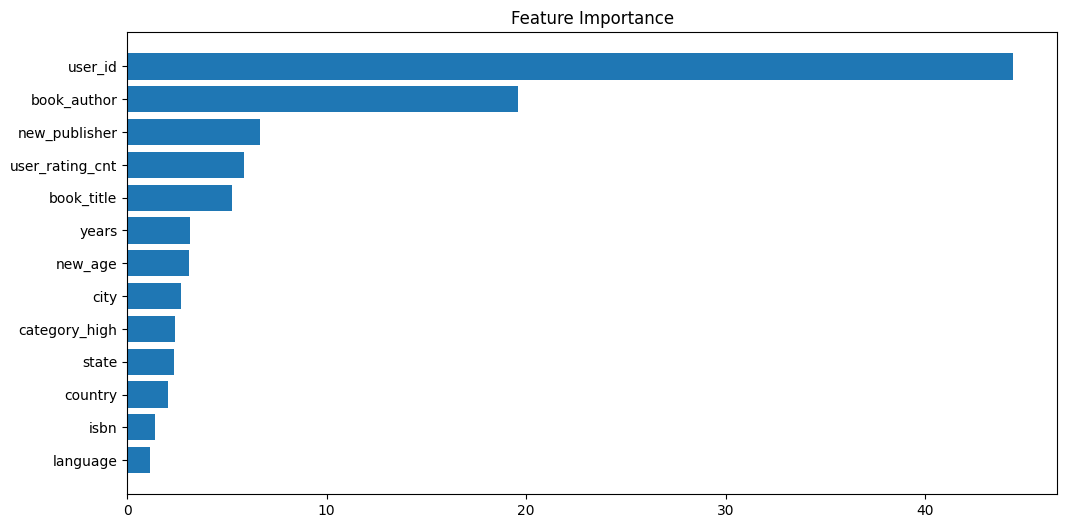

Valid Set 1 번째 Fold RMSE : 2.12952


 10%|█         | 1/10 [03:42<33:25, 222.79s/it]

0:	learn: 2.3074332	test: 2.2158434	test1: 2.2775690	best: 2.2775690 (0)	total: 205ms	remaining: 17m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.123473411
bestIteration = 231

Shrink model to first 232 iterations.


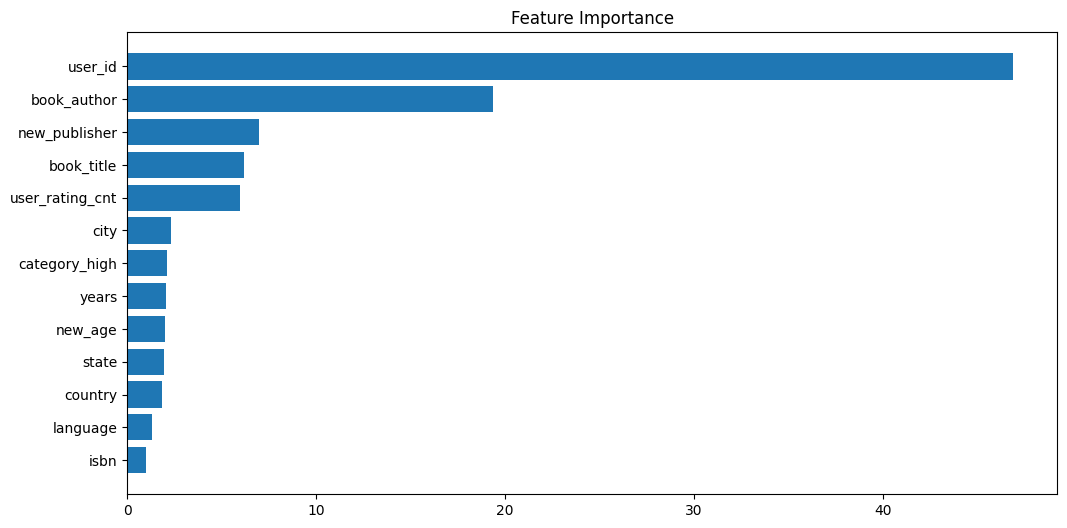

Valid Set 2 번째 Fold RMSE : 2.12347


 20%|██        | 2/10 [05:45<21:49, 163.64s/it]

0:	learn: 2.3055004	test: 2.2148149	test1: 2.2803210	best: 2.2803210 (0)	total: 231ms	remaining: 19m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.125346444
bestIteration = 312

Shrink model to first 313 iterations.


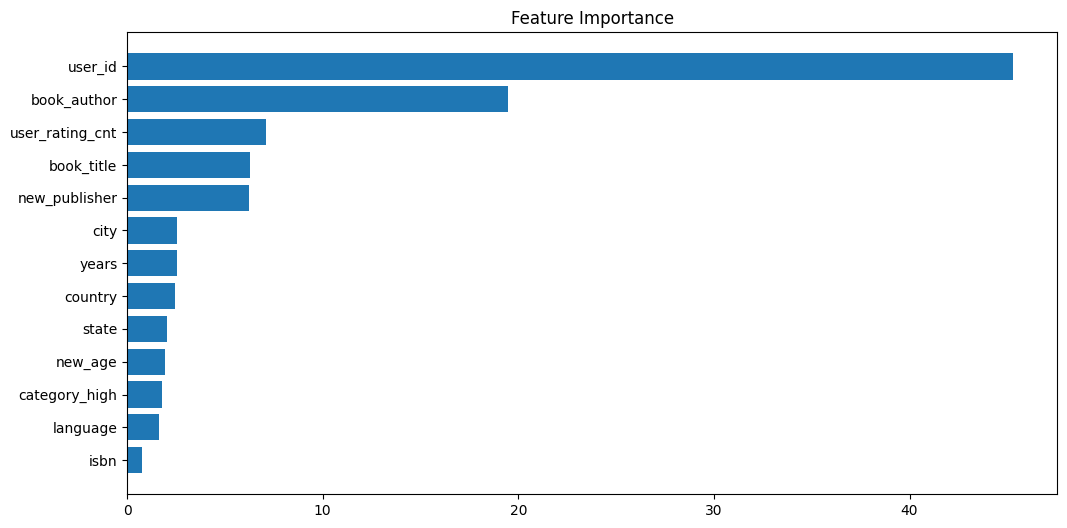

Valid Set 3 번째 Fold RMSE : 2.12535


 30%|███       | 3/10 [08:27<19:02, 163.15s/it]

0:	learn: 2.3057087	test: 2.2145058	test1: 2.2773773	best: 2.2773773 (0)	total: 215ms	remaining: 17m 56s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.13022042
bestIteration = 243

Shrink model to first 244 iterations.


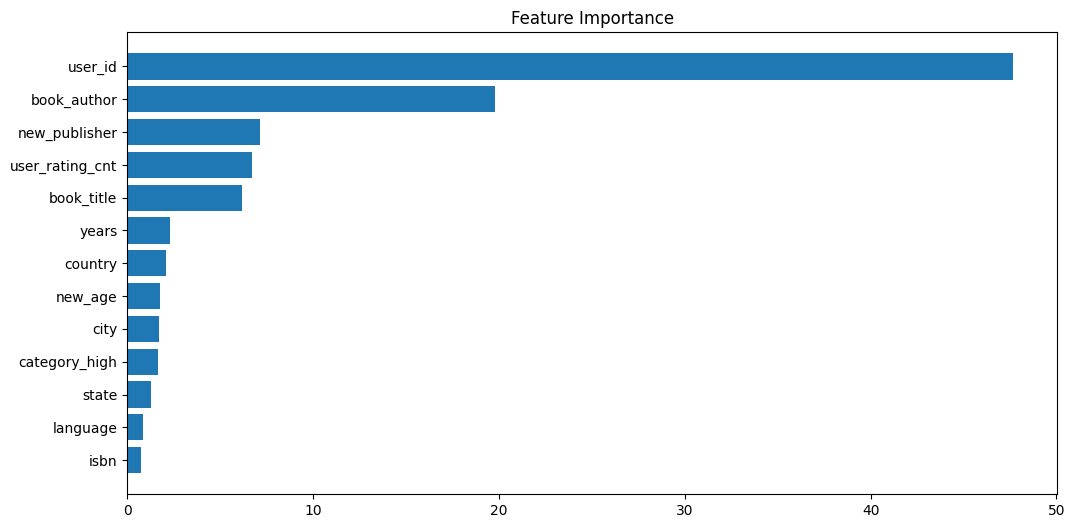

Valid Set 4 번째 Fold RMSE : 2.13022


 40%|████      | 4/10 [10:37<15:00, 150.15s/it]

0:	learn: 2.3061732	test: 2.2158714	test1: 2.2855389	best: 2.2855389 (0)	total: 206ms	remaining: 17m 9s
500:	learn: 2.1633126	test: 1.7054552	test1: 2.1333168	best: 2.1332362 (478)	total: 3m 4s	remaining: 27m 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.132766837
bestIteration = 564

Shrink model to first 565 iterations.


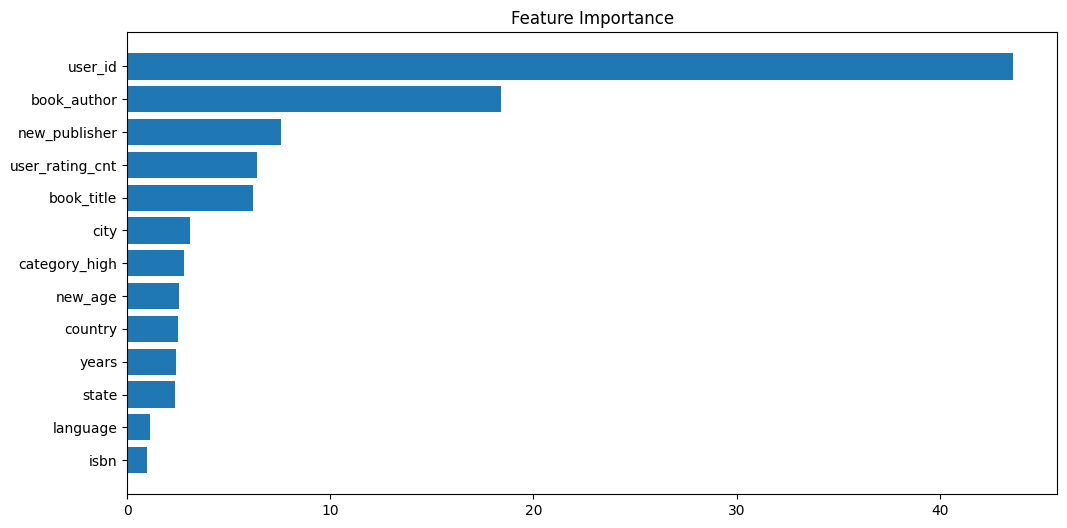

Valid Set 5 번째 Fold RMSE : 2.13277


 50%|█████     | 5/10 [14:48<15:32, 186.46s/it]

0:	learn: 2.3078712	test: 2.2147392	test1: 2.2836521	best: 2.2836521 (0)	total: 209ms	remaining: 17m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.131572575
bestIteration = 322

Shrink model to first 323 iterations.


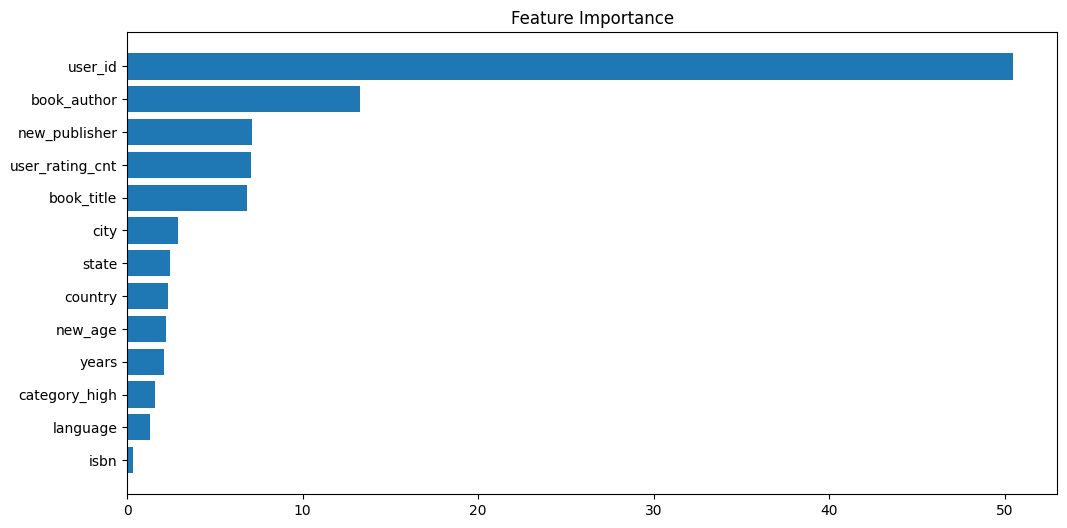

Valid Set 6 번째 Fold RMSE : 2.13157


 60%|██████    | 6/10 [17:31<11:53, 178.42s/it]

0:	learn: 2.3080268	test: 2.2167203	test1: 2.2814194	best: 2.2814194 (0)	total: 250ms	remaining: 20m 50s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.127900579
bestIteration = 283

Shrink model to first 284 iterations.


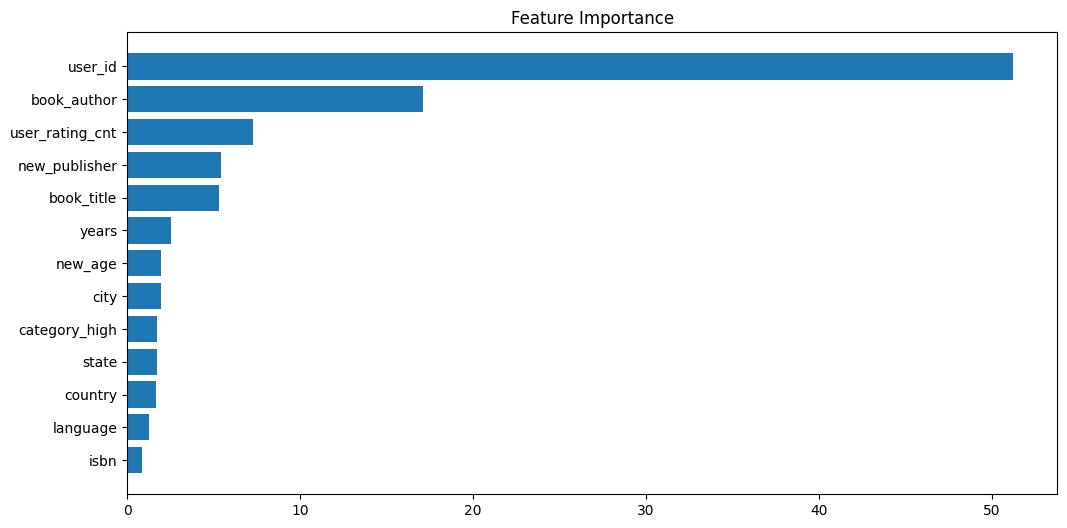

Valid Set 7 번째 Fold RMSE : 2.12790


 70%|███████   | 7/10 [20:02<08:28, 169.56s/it]

0:	learn: 2.3076412	test: 2.2146370	test1: 2.2836265	best: 2.2836265 (0)	total: 207ms	remaining: 17m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.136066488
bestIteration = 398

Shrink model to first 399 iterations.


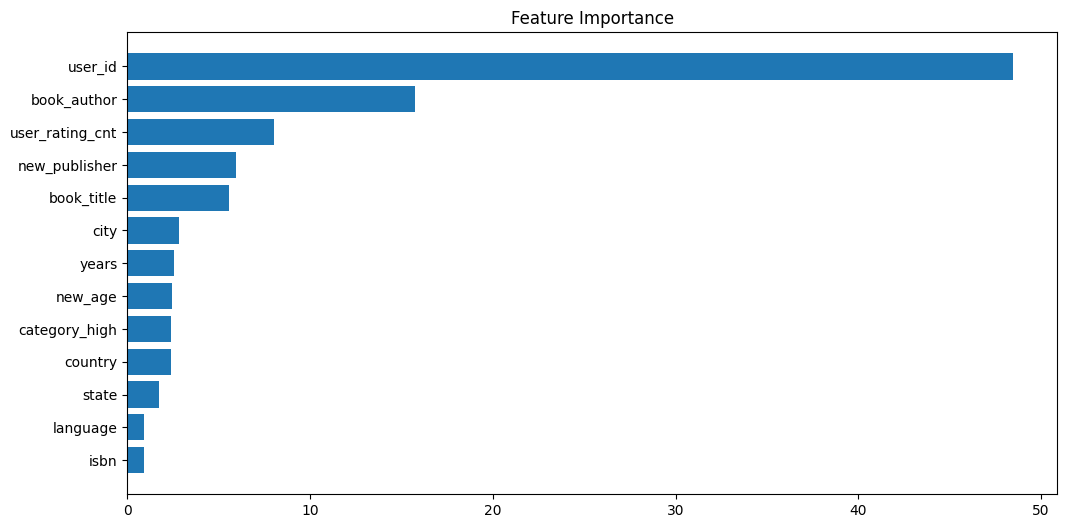

Valid Set 8 번째 Fold RMSE : 2.13607


 80%|████████  | 8/10 [23:12<05:51, 175.94s/it]

0:	learn: 2.3071539	test: 2.2154497	test1: 2.2815838	best: 2.2815838 (0)	total: 206ms	remaining: 17m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.129604677
bestIteration = 282

Shrink model to first 283 iterations.


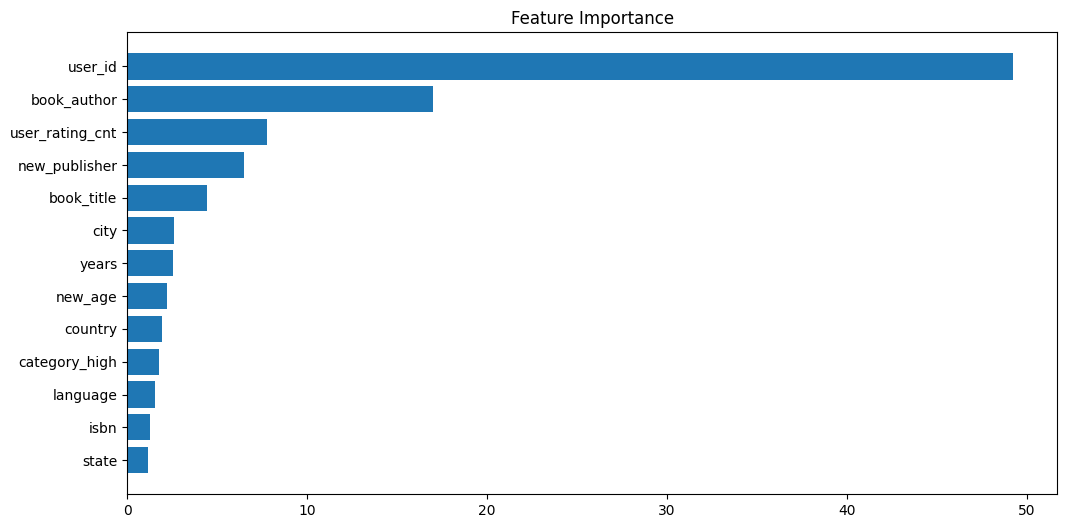

Valid Set 9 번째 Fold RMSE : 2.12960


 90%|█████████ | 9/10 [25:39<02:46, 166.86s/it]

0:	learn: 2.3071082	test: 2.2147463	test1: 2.2810698	best: 2.2810698 (0)	total: 203ms	remaining: 16m 56s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.128997597
bestIteration = 310

Shrink model to first 311 iterations.


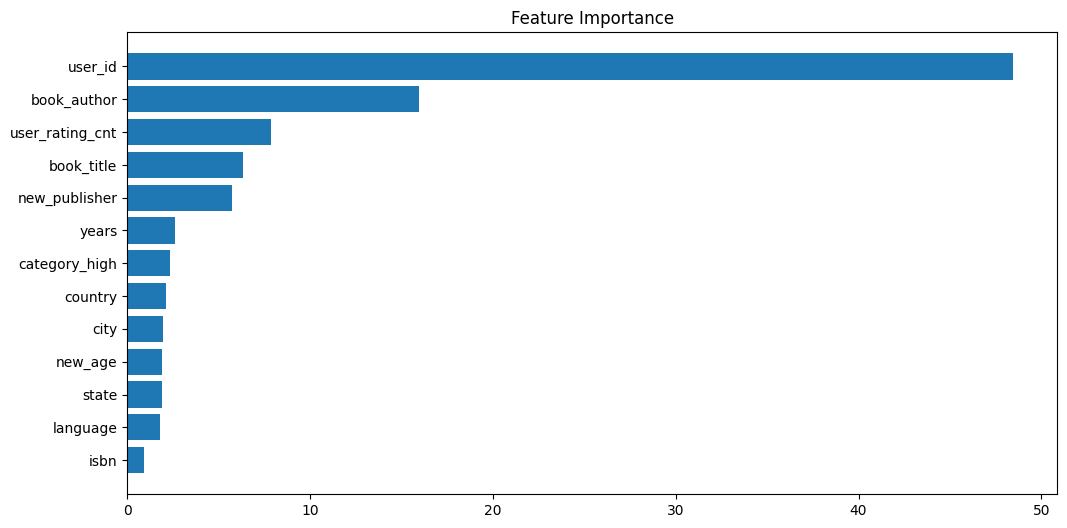

Valid Set 10 번째 Fold RMSE : 2.12900


100%|██████████| 10/10 [28:13<00:00, 169.38s/it]

CatBoost RMSE 평균 : 2.12955 



In [129]:
X_data, y_data = train_df.drop(columns = ['rating', 'user_rating_avg', 'book_rating_avg']), train_df['rating']

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = SEED)
valid_rmse = []
pred_df = pd.DataFrame()
cat_col = train_df.columns[[i for i in range(0, 12)]].tolist()

# Stratified K-Fold 사용하여 Best Parameter 학습
for fold, (train_idx, valid_idx) in tqdm.tqdm(enumerate(skf.split(X_data, y_data)), total = skf.n_splits) : 
    
    # Train Set과 Valid Set 분할    
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx]
    
    train_data = Pool(data = X_train, label = y_train, cat_features = cat_col)
    valid_data = Pool(data = X_valid, label = y_valid, cat_features = cat_col)
    
    # Best Parameter 학습
    param = study.best_params
    # param = {'learning_rate': 0.1, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}
    
    cat_reg = CatBoostRegressor(**param, iterations = 5000, 
                                loss_function = 'RMSE', eval_metric = 'RMSE', 
                                use_best_model = True, random_state = SEED,
                                cat_features = [i for i in range(0, 12)])
    cat_reg.fit(train_data, eval_set = [train_data, valid_data], use_best_model = True,
                verbose = 500, early_stopping_rounds = 100)
    
    # Feature Importance 출력
    feature_importance = cat_reg.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize = (12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align = 'center')
    plt.yticks(range(len(sorted_idx)), np.array(X_data.columns)[sorted_idx])
    plt.title('Feature Importance')
    plt.show()
    
    # 모델 RMSE 출력
    score = mean_squared_error(y_valid, cat_reg.predict(X_valid), squared = False)
    valid_rmse.append(score)
    print(f'Valid Set {fold + 1} 번째 Fold RMSE : {score:.5f}')
    
    # Predict
    pred = cat_reg.predict(test_df.drop(['rating'], axis = 1))
    pred_df[f'pred_{fold}'] = pred
    
print(f'CatBoost RMSE 평균 : {np.array(valid_rmse).mean():.5f} \n')

In [132]:
test_ratings['rating'] = (pred_df['pred_0'] + pred_df['pred_1'] + pred_df['pred_2'] + pred_df['pred_3'] + pred_df['pred_4'] + 
                     pred_df['pred_5'] + pred_df['pred_6'] + pred_df['pred_7'] + pred_df['pred_8'] + pred_df['pred_9']) / 10
submit = test_ratings[['user_id', 'isbn', 'rating']]
submit

,user_id,isbn,rating
0,11676,0002005018,7.216085
1,116866,0002005018,7.308520
2,152827,0060973129,7.340888
3,157969,0374157065,7.809797
4,67958,0399135782,7.603439
...,...,...,...
76694,278543,1576734218,6.178388
76695,278563,3492223710,6.112513
76696,278633,1896095186,6.519271
76697,278668,8408044079,5.190023


In [131]:
submit.to_csv('./code/submit/CB_HPO_Pred_AVG_rating_cnt.csv', index = False)

- best_params = {'learning_rate': 0.1, 'depth': 10, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}
    - LB : 2.2369 / CV : 1.7941

- best_params = {'learning_rate': 0.1, 'reg_lambda': 10, 'random_strength': 26, 'depth': 9, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3741523922560336}
    - LB : 2.2479 / CV : 1.7941

- best_params = {'depth': 11, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'random_strength': 0.001, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.739458755076581} 
    - LB : 2.2444 / CV : 1.78230

- best_params = {'learning_rate': 0.1, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'} (`CB_HPO_Pred_AVG.csv`)
    - LB : 2.1850 / CV : 1.76569 

- best_params = {'depth': 4, 'learning_rate': 0.5, 'l2_leaf_reg': 5, 'random_strength': 1e-05, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9714178680893226}  (`CB_HPO_add_Pred_AVG.csv`)
    - LB : 2.1903 / CV : 1.76660

- best_params = {'learning_rate': 0.1, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'} (`CB_HPO_Pred_AVG_no_avgrating.csv`)
    - 기존 변수들에서 `rating_Avg`를 제거한 상태로 학습
    - LB : 2.1279 / CV : 2.13052

- best_params = {'depth': 14, 'learning_rate': 0.5, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.04719272677899547} (`CB_HPO_Pred_AVG_no_avgrating_HPO.csv`)
    - 기존 변수들에서 `rating_Avg`를 제거한 상태로 학습
    - LB : 2.1332 / CV : 2.13758 

- best_params = {'depth': 6, 'learning_rate': 0.5, 'colsample_bylevel': 1.0, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9738981585202802}
    - `rating_cnt` 추가
    - LB : 2.1305 / CV : 2.12955

## LightGBM

In [14]:
def objectiveLGBM(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'boosting_type' : trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves' : trial.suggest_int('num_leaves', 30, 50),
        'max_depth' : trial.suggest_int('max_depth', 1, 15),
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-5, 1e-3, 0.1, 0.5]),
        'colsample_bytree' : trial.suggest_categorical('colsample_bytree', [0.1, 0.3, 0.5, 0.7, 1.0]),
        'subsample' : trial.suggest_categorical('subsample', [0.1, 0.3, 0.5, 0.7, 1.0]),
        'reg_alpha' : trial.suggest_categorical('reg_alpha', [1e-3, 0.1, 1, 5, 10]),
        'reg_lambda' : trial.suggest_categorical('reg_lambda', [1e-3, 0.1, 1, 5, 10]),
        'min_child_weight': trial.suggest_categorical('min_child_weight', [1e-3, 0.1, 1, 5, 10]),
    }
    lgbm_model = LGBMRegressor(**param, n_estimators = 5000, objective = 'regression', metric = 'rmse',
                               n_jobs = -1, verbose = -1, random_state = SEED)
    callback = lightgbm.early_stopping(stopping_rounds = 100)
    lgbm_model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],
                   eval_metric = 'rmse', callbacks = [callback])
    
    score = mean_squared_error(y_valid, lgbm_model.predict(X_valid), squared = False)
    return score

In [15]:
# Study Optuna
study = optuna.create_study(direction = 'minimize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objectiveLGBM(trial, X_train, y_train, X_valid, y_valid), n_trials = 50)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n') 

[I 2023-12-15 13:08:07,509] A new study created in memory with name: no-name-2b5465e9-b405-46d5-8a39-a72bff979798
[I 2023-12-15 13:13:22,558] Trial 0 finished with value: 1.9462932670262931 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'max_depth': 9, 'learning_rate': 0.5, 'colsample_bytree': 0.7, 'subsample': 1.0, 'reg_alpha': 1, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 0 with value: 1.9462932670262931.
[I 2023-12-15 13:23:04,161] Trial 1 finished with value: 2.7512655857240094 and parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'max_depth': 5, 'learning_rate': 0.001, 'colsample_bytree': 0.5, 'subsample': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 10, 'min_child_weight': 0.1}. Best is trial 0 with value: 1.9462932670262931.
[I 2023-12-15 13:27:42,611] Trial 2 finished with value: 7.630890264743444 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': 15, 'learning_rate': 0.5, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 10, '

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 2.12043	valid_1's rmse: 2.1288


[I 2023-12-15 13:28:02,097] Trial 3 finished with value: 2.1288043693622063 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'max_depth': 5, 'learning_rate': 0.001, 'colsample_bytree': 0.1, 'subsample': 0.1, 'reg_alpha': 10, 'reg_lambda': 10, 'min_child_weight': 0.001}. Best is trial 0 with value: 1.9462932670262931.
[I 2023-12-15 13:31:12,186] Trial 4 finished with value: 7.395880250694369 and parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'max_depth': 5, 'learning_rate': 0.5, 'colsample_bytree': 0.1, 'subsample': 0.3, 'reg_alpha': 10, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 0 with value: 1.9462932670262931.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 1.89957	valid_1's rmse: 1.9121


[I 2023-12-15 13:31:24,501] Trial 5 finished with value: 1.912103023622258 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'max_depth': 1, 'learning_rate': 0.001, 'colsample_bytree': 0.7, 'subsample': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 10, 'min_child_weight': 10}. Best is trial 5 with value: 1.912103023622258.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 1.91529	valid_1's rmse: 1.92689


[I 2023-12-15 13:31:37,414] Trial 6 finished with value: 1.9268898092436648 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'max_depth': 2, 'learning_rate': 0.001, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 5, 'reg_lambda': 0.001, 'min_child_weight': 0.001}. Best is trial 5 with value: 1.912103023622258.
[I 2023-12-15 13:37:40,556] Trial 7 finished with value: 7.040715559633694 and parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'max_depth': 3, 'learning_rate': 1e-05, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 5 with value: 1.912103023622258.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:37:41,548] Trial 8 finished with value: 1.8746150189688395 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 11, 'learning_rate': 0.5, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 1, 'reg_lambda': 1, 'min_child_weight': 0.001}. Best is trial 8 with value: 1.8746150189688395.


Early stopping, best iteration is:
[60]	training's rmse: 1.82236	valid_1's rmse: 1.87462


[I 2023-12-15 13:39:44,804] Trial 9 finished with value: 7.143864739495544 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': 1, 'learning_rate': 0.5, 'colsample_bytree': 0.1, 'subsample': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 10, 'min_child_weight': 0.001}. Best is trial 8 with value: 1.8746150189688395.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[723]	training's rmse: 1.77405	valid_1's rmse: 1.85849


[I 2023-12-15 13:39:48,696] Trial 10 finished with value: 1.8584892610762904 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 10 with value: 1.8584892610762904.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[723]	training's rmse: 1.77405	valid_1's rmse: 1.85849


[I 2023-12-15 13:39:52,377] Trial 11 finished with value: 1.8584892610762904 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 10 with value: 1.8584892610762904.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:39:55,595] Trial 12 finished with value: 1.857775242096866 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[552]	training's rmse: 1.7623	valid_1's rmse: 1.85778
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:39:58,378] Trial 13 finished with value: 1.8585193975128478 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[425]	training's rmse: 1.77931	valid_1's rmse: 1.85852
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:40:01,583] Trial 14 finished with value: 1.857775242096866 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[552]	training's rmse: 1.7623	valid_1's rmse: 1.85778
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:40:04,694] Trial 15 finished with value: 1.8589018676501479 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[528]	training's rmse: 1.7728	valid_1's rmse: 1.8589
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:40:07,616] Trial 16 finished with value: 1.8577964842982615 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[423]	training's rmse: 1.77454	valid_1's rmse: 1.8578
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 2.38464	valid_1's rmse: 2.38748


[I 2023-12-15 13:40:54,741] Trial 17 finished with value: 2.387477835090298 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'max_depth': 10, 'learning_rate': 1e-05, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.001, 'min_child_weight': 0.1}. Best is trial 12 with value: 1.857775242096866.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:40:57,363] Trial 18 finished with value: 1.8587716897589244 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 14, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 5, 'min_child_weight': 10}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[377]	training's rmse: 1.7925	valid_1's rmse: 1.85877
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:41:01,099] Trial 19 finished with value: 1.8582821669272167 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[573]	training's rmse: 1.76466	valid_1's rmse: 1.85828
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:41:04,206] Trial 20 finished with value: 1.8588447516713684 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 1.0, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[539]	training's rmse: 1.78037	valid_1's rmse: 1.85884
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:41:07,260] Trial 21 finished with value: 1.8587113110373277 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 12 with value: 1.857775242096866.


Early stopping, best iteration is:
[518]	training's rmse: 1.76278	valid_1's rmse: 1.85871
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:41:11,075] Trial 22 finished with value: 1.8575745931789833 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 22 with value: 1.8575745931789833.


Early stopping, best iteration is:
[650]	training's rmse: 1.73984	valid_1's rmse: 1.85757
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:41:14,329] Trial 23 finished with value: 1.85818538329485 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 11, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 22 with value: 1.8575745931789833.


Early stopping, best iteration is:
[522]	training's rmse: 1.75685	valid_1's rmse: 1.85819
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 2.38463	valid_1's rmse: 2.38747


[I 2023-12-15 13:42:01,821] Trial 24 finished with value: 2.3874743996148307 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': 13, 'learning_rate': 1e-05, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 22 with value: 1.8575745931789833.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:42:04,560] Trial 25 finished with value: 1.8585842402412496 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 14, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.1, 'reg_alpha': 5, 'reg_lambda': 0.001, 'min_child_weight': 10}. Best is trial 22 with value: 1.8575745931789833.


Early stopping, best iteration is:
[409]	training's rmse: 1.78549	valid_1's rmse: 1.85858
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:42:08,033] Trial 26 finished with value: 1.8584412191840736 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 11, 'learning_rate': 0.1, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 0.1}. Best is trial 22 with value: 1.8575745931789833.


Early stopping, best iteration is:
[524]	training's rmse: 1.75144	valid_1's rmse: 1.85844
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:42:10,480] Trial 27 finished with value: 1.8600474860038052 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'max_depth': 14, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 22 with value: 1.8575745931789833.


Early stopping, best iteration is:
[350]	training's rmse: 1.78709	valid_1's rmse: 1.86005
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:42:14,359] Trial 28 finished with value: 1.8574871315861985 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Early stopping, best iteration is:
[736]	training's rmse: 1.76218	valid_1's rmse: 1.85749


[I 2023-12-15 13:52:56,996] Trial 29 finished with value: 7.039681670015834 and parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'max_depth': 10, 'learning_rate': 1e-05, 'colsample_bytree': 0.7, 'subsample': 1.0, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 28 with value: 1.8574871315861985.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:53:00,438] Trial 30 finished with value: 1.8585056496616352 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Early stopping, best iteration is:
[577]	training's rmse: 1.77664	valid_1's rmse: 1.85851
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:53:03,316] Trial 31 finished with value: 1.8587658341672764 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Early stopping, best iteration is:
[460]	training's rmse: 1.78252	valid_1's rmse: 1.85877
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:53:06,052] Trial 32 finished with value: 1.8582679416830166 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 5, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Early stopping, best iteration is:
[474]	training's rmse: 1.78822	valid_1's rmse: 1.85827
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 13:53:09,461] Trial 33 finished with value: 1.8582230064307186 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'subsample': 1.0, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 0.1}. Best is trial 28 with value: 1.8574871315861985.


Early stopping, best iteration is:
[505]	training's rmse: 1.76928	valid_1's rmse: 1.85822


[I 2023-12-15 14:04:53,433] Trial 34 finished with value: 2.6918320047613067 and parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'max_depth': 10, 'learning_rate': 0.001, 'colsample_bytree': 1.0, 'subsample': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[755]	training's rmse: 1.8458	valid_1's rmse: 1.8692


[I 2023-12-15 14:04:57,793] Trial 35 finished with value: 1.869200286893409 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.1, 'subsample': 0.5, 'reg_alpha': 1, 'reg_lambda': 1, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.
[I 2023-12-15 14:09:39,168] Trial 36 finished with value: 6.48642594539177 and parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'max_depth': 14, 'learning_rate': 0.5, 'colsample_bytree': 0.5, 'subsample': 0.1, 'reg_alpha': 10, 'reg_lambda': 10, 'min_child_weight': 1}. Best is trial 28 with value: 1.8574871315861985.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 1.84985	valid_1's rmse: 1.87116


[I 2023-12-15 14:10:17,376] Trial 37 finished with value: 1.871155010870594 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 7, 'learning_rate': 0.001, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.001, 'min_child_weight': 10}. Best is trial 28 with value: 1.8574871315861985.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[786]	training's rmse: 1.75786	valid_1's rmse: 1.85858


[I 2023-12-15 14:10:21,593] Trial 38 finished with value: 1.858578974238592 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.3, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.
[I 2023-12-15 14:19:13,978] Trial 39 finished with value: 5.036427020323276 and parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 11, 'learning_rate': 0.5, 'colsample_bytree': 0.1, 'subsample': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 1.86132	valid_1's rmse: 1.8763


[I 2023-12-15 14:19:38,249] Trial 40 finished with value: 1.8763005927508853 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'max_depth': 4, 'learning_rate': 0.001, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 10, 'reg_lambda': 10, 'min_child_weight': 0.001}. Best is trial 28 with value: 1.8574871315861985.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 14:19:42,482] Trial 41 finished with value: 1.857660253962212 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 28 with value: 1.8574871315861985.


Early stopping, best iteration is:
[697]	training's rmse: 1.73274	valid_1's rmse: 1.85766
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 14:19:47,268] Trial 42 finished with value: 1.8570557359879565 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 42 with value: 1.8570557359879565.


Early stopping, best iteration is:
[728]	training's rmse: 1.72591	valid_1's rmse: 1.85706
Training until validation scores don't improve for 100 rounds


[I 2023-12-15 14:19:50,756] Trial 43 finished with value: 1.8584288407622231 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.1, 'min_child_weight': 5}. Best is trial 42 with value: 1.8570557359879565.


Early stopping, best iteration is:
[527]	training's rmse: 1.7551	valid_1's rmse: 1.85843
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[737]	training's rmse: 1.76437	valid_1's rmse: 1.85693


[I 2023-12-15 14:19:54,867] Trial 44 finished with value: 1.8569333368094627 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 44 with value: 1.8569333368094627.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[737]	training's rmse: 1.76437	valid_1's rmse: 1.85693


[I 2023-12-15 14:19:59,063] Trial 45 finished with value: 1.8569333368094627 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 44 with value: 1.8569333368094627.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 2.41605	valid_1's rmse: 2.41838


[I 2023-12-15 14:20:34,207] Trial 46 finished with value: 2.418384658168914 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 12, 'learning_rate': 1e-05, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 44 with value: 1.8569333368094627.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[623]	training's rmse: 1.77565	valid_1's rmse: 1.85765


[I 2023-12-15 14:20:37,907] Trial 47 finished with value: 1.8576454680744567 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 11, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 44 with value: 1.8569333368094627.
[I 2023-12-15 14:25:54,759] Trial 48 finished with value: 6.307307968382457 and parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'max_depth': 10, 'learning_rate': 0.5, 'colsample_bytree': 0.3, 'subsample': 1.0, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 44 with value: 1.8569333368094627.


Training until validation scores don't improve for 100 rounds


[I 2023-12-15 14:25:58,069] Trial 49 finished with value: 1.8577011339968028 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 44 with value: 1.8569333368094627.


Early stopping, best iteration is:
[517]	training's rmse: 1.78368	valid_1's rmse: 1.8577
Best trial : score 1.8569333368094627, 
 params = {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 1} 



In [16]:
X_data, y_data = train_GB.drop(columns = 'rating'), train_GB['rating']

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = SEED)
valid_rmse = []
pred_df = pd.DataFrame()

# Stratified K-Fold 사용하여 Best Parameter 학습
for fold, (train_idx, valid_idx) in tqdm.tqdm(enumerate(skf.split(X_data, y_data)), total = skf.n_splits) :
    
    # Train Set과 Valid Set 분할    
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx]
    
    # Best Parameter 학습
    param = study.best_params # lgbm_best_params
    
    lgbm_reg = LGBMRegressor(**param, n_estimators = 5000, objective = 'regression', metric = 'rmse',
                             n_jobs = -1, verbose = -1, random_state = SEED)
    callback = lightgbm.early_stopping(stopping_rounds = 100)
    lgbm_reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],
                   eval_metric = 'rmse', callbacks = [callback])
    
    # 모델 RMSE 출력
    score = mean_squared_error(y_valid, lgbm_reg.predict(X_valid), squared = False)
    valid_rmse.append(score)
    print(f'Valid Set {fold + 1} 번째 Fold RMSE : {score:.5f}')

    # Predict
    pred = lgbm_reg.predict(test_GB.drop(['rating'], axis = 1))
    pred_df[f'pred_{fold}'] = pred

print(f'LGBM RMSE 평균 : {np.array(valid_rmse).mean():.5f} \n')

  0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[669]	training's rmse: 1.77124	valid_1's rmse: 1.84505
Valid Set 1 번째 Fold RMSE : 1.84505


 10%|█         | 1/10 [00:04<00:39,  4.36s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[709]	training's rmse: 1.76938	valid_1's rmse: 1.84211
Valid Set 2 번째 Fold RMSE : 1.84211


 20%|██        | 2/10 [00:08<00:35,  4.46s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[750]	training's rmse: 1.76591	valid_1's rmse: 1.83455
Valid Set 3 번째 Fold RMSE : 1.83455


 30%|███       | 3/10 [00:13<00:32,  4.58s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[723]	training's rmse: 1.76602	valid_1's rmse: 1.84613
Valid Set 4 번째 Fold RMSE : 1.84613


 40%|████      | 4/10 [00:17<00:26,  4.46s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[955]	training's rmse: 1.74373	valid_1's rmse: 1.84995
Valid Set 5 번째 Fold RMSE : 1.84995


 50%|█████     | 5/10 [00:23<00:24,  4.96s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[919]	training's rmse: 1.74868	valid_1's rmse: 1.85163
Valid Set 6 번째 Fold RMSE : 1.85163


 60%|██████    | 6/10 [00:29<00:20,  5.22s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[691]	training's rmse: 1.76928	valid_1's rmse: 1.84911
Valid Set 7 번째 Fold RMSE : 1.84911


 70%|███████   | 7/10 [00:33<00:14,  4.92s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[877]	training's rmse: 1.75255	valid_1's rmse: 1.85598
Valid Set 8 번째 Fold RMSE : 1.85598


 80%|████████  | 8/10 [00:39<00:10,  5.08s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[813]	training's rmse: 1.76037	valid_1's rmse: 1.84043
Valid Set 9 번째 Fold RMSE : 1.84043


 90%|█████████ | 9/10 [00:44<00:05,  5.06s/it]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[651]	training's rmse: 1.77385	valid_1's rmse: 1.85223
Valid Set 10 번째 Fold RMSE : 1.85223


100%|██████████| 10/10 [00:48<00:00,  4.83s/it]

LGBM RMSE 평균 : 1.84672 



<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

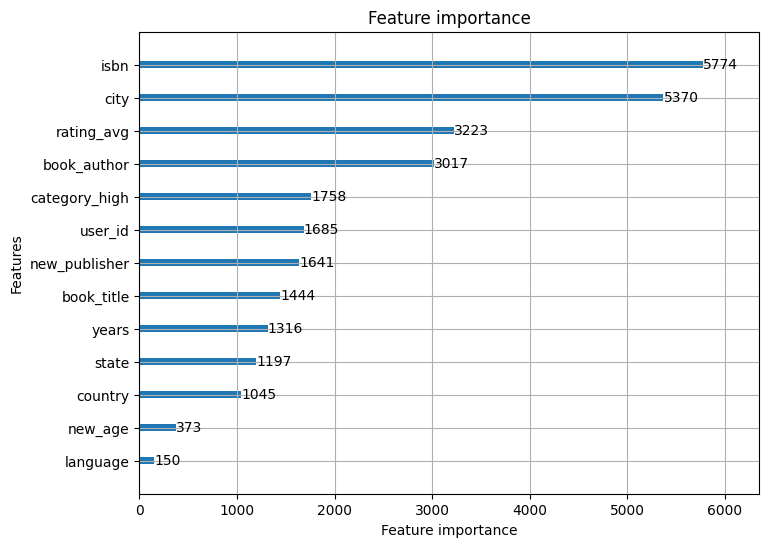

In [17]:
# Feature Importance
fig, ax = plt.subplots(figsize = (8, 6))
lgbm_plot_importance(lgbm_reg, ax = ax)

In [18]:
test_ratings['rating'] = (pred_df['pred_0'] + pred_df['pred_1'] + pred_df['pred_2'] + pred_df['pred_3'] + pred_df['pred_4'] + 
                          pred_df['pred_5'] + pred_df['pred_6'] + pred_df['pred_7'] + pred_df['pred_8'] + pred_df['pred_9']) / 10
submit = test_ratings[['user_id', 'isbn', 'rating']]
submit

,user_id,isbn,rating
0,11676,0002005018,6.949023
1,116866,0002005018,7.718842
2,152827,0060973129,8.618080
3,157969,0374157065,7.926602
4,67958,0399135782,8.120157
...,...,...,...
76694,278543,1576734218,6.351776
76695,278563,3492223710,7.332121
76696,278633,1896095186,7.038254
76697,278668,8408044079,3.432230


In [19]:
submit.to_csv('./code/submit/LGBM_HPO_Pred_AVG.csv', index = False)

In [20]:
submit['rating'] = submit['rating'].round().astype(int)
submit.to_csv('./code/submit/LGBM_HPO_Pred_AVG_round.csv', index = False)

- {'boosting_type': 'gbdt', 'num_leaves': 33, 'max_depth': 3, 'learning_rate': 0.5, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 1}
    - LB : 2.2771 / CV : 1.85789

## XGBoost

In [16]:
def objectiveXGB(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'booster' : trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'max_depth' : trial.suggest_int('max_depth', 1, 15),
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-3, 0.01, 0.05, 0.1, 0.5]), # 1e-5,
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 10),
        'gamma' : trial.suggest_categorical('alpha', [1e-5, 1e-3, 1, 5, 10]),
        'colsample_bytree' : trial.suggest_categorical('colsample_bytree', [0.1, 0.5, 1]),
        'lambda' : trial.suggest_categorical('lambda', [1e-5, 1e-3, 1, 5, 10]),
        'alpha' : trial.suggest_categorical('alpha', [1e-5, 1e-3, 1, 5, 10]),
        'subsample' : trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'max_delta_step' : trial.suggest_categorical('max_delta_step', [0.1, 0.5, 1, 5, 10]),
    }
    
    # XGBRegressor 사용
    model = XGBRegressor(**param, n_estimators = 3000, objective = 'reg:squarederror', eval_metric = 'rmse',
                         nthread = -1, gpu_id = 0, tree_method = 'gpu_hist', predictor = 'gpu_predictor',
                         early_stopping_rounds = 100, random_state = SEED)
    xgb_model = model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = 300)
    
    # Valid Set RMSE 계산
    score = mean_squared_error(y_valid, xgb_model.predict(X_valid), squared = False)
    return score

In [ ]:
# Study Optuna
study = optuna.create_study(direction = 'minimize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objectiveXGB(trial, X_train, y_train, X_valid, y_valid), n_trials = 30)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n')

In [19]:
xgb_best_params = {'booster': 'dart', 'max_depth': 12, 'learning_rate': 0.01, 'min_child_weight': 6, 'alpha': 0.001, 'colsample_bytree': 0.5, 'lambda': 10, 'subsample': 0.7, 'max_delta_step': 0.5}

In [ ]:
X_data, y_data = train_GB.drop(columns = 'rating'), train_GB['rating']

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = SEED)
valid_rmse = []
pred_df = pd.DataFrame()

# Stratified K-Fold 사용하여 Best Parameter 학습
for fold, (train_idx, valid_idx) in tqdm.tqdm(enumerate(skf.split(X_data, y_data)), total = skf.n_splits) :
    
    # Train Set과 Valid Set 분할    
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx]
    
    # Best Parameter 학습
    param = xgb_best_params # study.best_params
    
    # Best Parameter 학습
    xgb_reg = XGBRegressor(**param, n_estimators = 5000, objective = 'reg:squarederror', eval_metric = 'rmse', 
                           nthread = -1, gpu_id = 0, tree_method = 'gpu_hist', predictor = 'gpu_predictor',
                           early_stopping_rounds = 100, random_state = SEED)
    xgb_reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = False)
    
    # 모델 RMSE 출력
    score = mean_squared_error(y_valid, xgb_reg.predict(X_valid), squared = False)
    valid_rmse.append(score)
    print(f'Valid Set {fold + 1} 번째 Fold RMSE : {score:.5f}')
    
    # Predict
    pred = xgb_reg.predict(test_GB.drop(['rating'], axis = 1))
    pred_df[f'pred_{fold}'] = pred

print(f'XGBoost RMSE 평균 : {np.array(valid_rmse).mean():.5f} \n')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

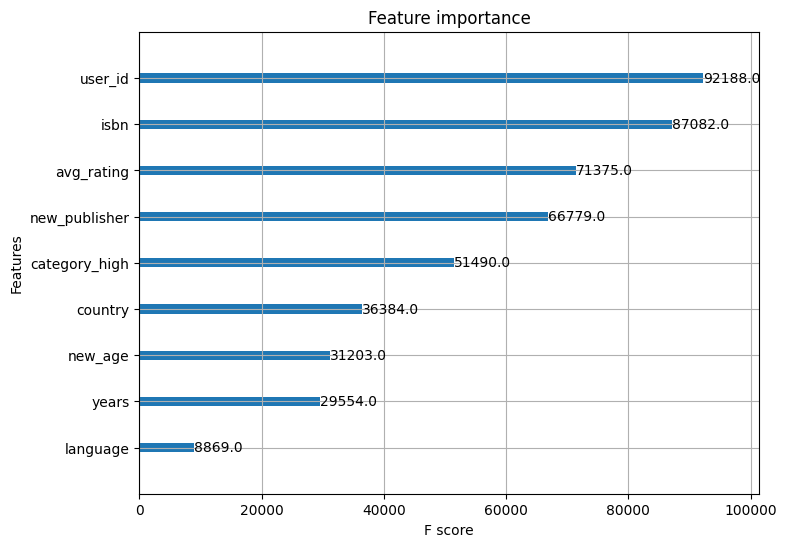

In [ ]:
# Feature Importance
fig, ax = plt.subplots(figsize = (8, 6))
xgb_plot_importance(xgb_reg, ax = ax)

In [ ]:
test_ratings['rating'] = (pred_df['pred_0'] + pred_df['pred_1'] + pred_df['pred_2'] + pred_df['pred_3'] + pred_df['pred_4'] + 
                          pred_df['pred_5'] + pred_df['pred_6'] + pred_df['pred_7'] + pred_df['pred_8'] + pred_df['pred_9']) / 10
submit = test_ratings[['user_id', 'isbn', 'rating']]
submit

,user_id,isbn,rating
0,11676,0002005018,7.066980
1,116866,0002005018,7.668482
2,152827,0060973129,8.320372
3,157969,0374157065,7.769433
4,67958,0399135782,8.436759
...,...,...,...
76694,278543,1576734218,6.505219
76695,278563,3492223710,6.650600
76696,278633,1896095186,6.597798
76697,278668,8408044079,2.813656


In [ ]:
submit.to_csv('./code/submit/XGB_HPO_Pred_AVG.csv', index = False)

In [ ]:
submit['rating'] = submit['rating'].round().astype(int)
submit.to_csv('./code/submit/XGB_HPO_Pred_AVG_round.csv', index = False)